In [302]:
import os
import pandas as pd
import numpy as np
from datetime import datetime


import matplotlib.pyplot as plt
from importlib import reload

import Tree
reload(Tree)
from Tree import *

import forecast_prophet
reload(forecast_prophet)
from forecast_prophet import *

import forecast_ucm
reload(forecast_ucm)
from forecast_ucm import *

import forecast_sarimax
reload(forecast_sarimax)
from forecast_sarimax import *

import utils
reload(utils)
from utils import *

import main
reload(main)
from main import *


# path='c:\\Users\\31683\\Desktop\\data\\M5'
# Y_path=path+f"\\sales_train_validation.pkl"  # to data file 
# Y_path_eval=path+f"\\sales_train_evaluation.pkl" 
# X_path_val_eval=path+f"\\prices_train_val_eval.pkl"  # to data file
# df_holidays=pd.read_csv(path+f"\\holidays.csv")
# iOoS=28
# df_data=pd.read_pickle(Y_path)
# df_data.drop(columns=['2011-01-29','2011-01-30'],inplace=True) #start on Monday  #TODO move this to temporal part in getmY

# df_data_eval=pd.read_pickle(Y_path_eval)
slices=[7,1]

# l_methods=["bottom_up", "top_down_ph" ,"top_down_hp", 'wls',
#                   "ols" ,'mint_sample','mint_shrink','mint_diag']
l_methods_temporal=["bottom_up", "top_down_ph" ,"top_down_hp","wls_svar" , "ols",
                    "wls_acov", "wls_struct" , "wls_hvar" , 
                    "mint_sample", "mint_shrink" , "mint_diag" ]




In [303]:


path='c:\\Users\\31683\\Desktop\\data\\M5'
Y_path=path+f"\\sales_train_validation.pkl"  # to data file  
# prepare_prices(path)  #WHAT DOES THIS DO?
price_path=path+f"\\prices_train_val_eval.pkl"

df_data=pd.read_pickle(Y_path)
df_data.iloc[:,:4]=df_data.iloc[:,:4].astype('string') # change the type to string so that groupby maintains store and dept ids
df_data.drop(columns=['2011-01-29','2011-01-30'],inplace=True) #start on Monday

df_holidays=pd.read_csv(path+f"\\holidays.csv")
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

df_price=pd.read_pickle(price_path,compression='gzip')
df_price.drop(columns=['2011-01-29','2011-01-30'],inplace=True)

df_snap=pd.read_csv(path+f"\\calendar.csv")[['snap_CA','snap_WI','snap_TX']]
df_snap.columns=[['CA','WI','TX']]
df_snap=df_snap[2:].reset_index()
df_snap.T.columns=df_price.columns[5:]
df_snap=pd.merge(df_price.iloc[:,:5],df_snap.T,left_on='state_id',right_index=True)

vW=np.loadtxt(path+f"\\weights.txt")  #m5 competition weights
vW=vW[:114]  #drop subsetting if product level data is added

#delete below if item level is added
df_price=df_price.groupby(['state_id','store_id','cat_id','dept_id']).mean().reset_index()
df_price=df_price.drop(columns=['item_id'])
df_snap=df_snap.groupby(['state_id','store_id','cat_id','dept_id']).max().reset_index()
df_snap=df_snap.drop(columns=['item_id'])

In [304]:
iOoS=7  # at the bottom forecast frequency if temporal
leaf=7
i=leaf
# sModel='lltrend'
sTempRecMethod='wls_acov'

In [305]:
dfPrice=df_price
dfSNAP=df_snap
dfHolidays=df_holidays

tree_spatial=Tree(dfData=df_data, sType='spatial')
mYhatIS = np.zeros((tree_spatial.mY.shape[0], tree_spatial.mY.shape[1]))
mRes = np.zeros((tree_spatial.mY.shape[0], tree_spatial.mY.shape[1]))
                        
n=tree_spatial.mY.shape[0]
m=iOoS
tree_spatial.mYhat=np.zeros((n,m))

tree_price=Tree(dfData = dfPrice , sType='spatial')
tree_snap=Tree(dfData = dfSNAP , sType= 'spatial') 

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [306]:


df=pd.DataFrame(
                    data={'price': tree_price.mY[i, :], 'snap': tree_snap.mY[i, :]},
                    index=tree_price.date_time_index[:] )
df.snap=(df.snap!=0).astype(int)

dfHolidays.loc[(dfHolidays.date.dt.day != 25) & (dfHolidays.date.dt.month != 12), "holidays"] = 1
dfHolidays.loc[(dfHolidays.date.dt.day == 25) & (dfHolidays.date.dt.month == 12), "christmas"] = 1
dfHolidays.set_index('date')
dfHolidays[['holidays','christmas']]=dfHolidays[['holidays','christmas']].fillna(0).astype(int)

df=pd.merge(df,dfHolidays, left_index=True,  right_on='date', how='left' )
df=df.fillna(0)
df[['holidays','christmas']]=df[['holidays','christmas']].astype(int)

dfY=pd.DataFrame(data=tree_spatial.mY[i,:], index=tree_spatial.date_time_index[:] , columns=['y'])
df.set_index('date',inplace=True)
df=pd.merge(df,dfY, left_index=True,  right_index=True, how='left' ) 
df



price  snap  holidays  christmas       y
date                                                
2011-01-31  27.60     0         0          0 1386.00
2011-02-01  27.60     1         0          0 1440.00
2011-02-02  27.60     1         0          0 1536.00
2011-02-03  27.60     1         0          0 1389.00
2011-02-04  27.60     1         0          0 1469.00
...           ...   ...       ...        ...     ...
2016-06-15  30.66     0         0          0     NaN
2016-06-16  30.66     0         0          0     NaN
2016-06-17  30.66     0         0          0     NaN
2016-06-18  30.66     0         0          0     NaN
2016-06-19  30.66     0         1          0     NaN

[1967 rows x 5 columns]

## Bias correction via temporal reconciliation:
Problem: UCM or SARIMA or anyother model can not always capture the intra daily dynamics. Error is not stable per daily forecast horizon
Solution: Based on in sample error magnitude  (within level ?) give more room to adjust to the leaf(horizon) that has the largest error (within level)

In [307]:
tree_temporal=Tree(dfData=df[['y']].dropna(), sType='temporal' , iLeaf=i)
tree_temporal.forecast(iOoS=iOoS ,sModel='sarimax', dfHolidays=df[['holidays','christmas']], 
                           dfSNAP=df[['snap']] , 
                           dfPrice=df[['price']], 
                           sTempRecMethod=None)

In [309]:
mRes=tree_temporal.mRes.copy()

# mRes=mRes[:,~np.all(np.isnan(mRes), axis=0)]
mW = np.eye(mRes.shape[0])
# vNonNanRows = np.setdiff1d(np.arange(0,mRes.shape[0]),  np.unique(np.argwhere(np.isnan(mRes))[:,0]))
# mRes = mRes[vNonNanRows,:]
n=mRes.shape[0]
m=mRes.shape[1]
# mSigma = (mRes@mRes.T)/m
                
mRes_centered = mRes - np.mean(mRes, axis=1).reshape(n,1)
mSigma = (mRes_centered@mRes_centered.T)/(m-1)

for l,level in enumerate(tree_temporal.levels):
                mRes_centered_level=split_matrix(mRes_centered,tree_temporal.dLevels)[l]
                mSigma_level=(mRes_centered_level@mRes_centered_level.T)/(m-1)
                
                if l==0:
                    mW=diag_mat([mSigma_level])
                else:
                    mW=diag_mat([mW,mSigma_level])    

In [320]:
mW[1:,1:].shape

(7, 7)

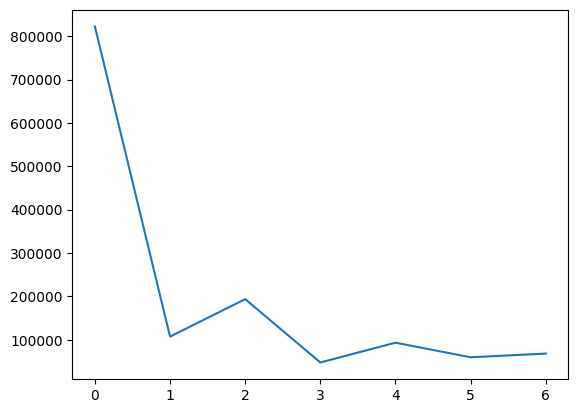

In [321]:
plt.plot(np.diag(mW[1:,1:]))

In [322]:
acovf(split_matrix(tree_temporal.mY,tree_temporal.dLevels)[0].flatten('F'), nlag=7)[1:]

array([4973556.05859833, 4800880.60204148, 4651782.11002193,
       4704882.1029277 , 4490758.87452366, 4261655.7016282 ,
       4158394.35938927])

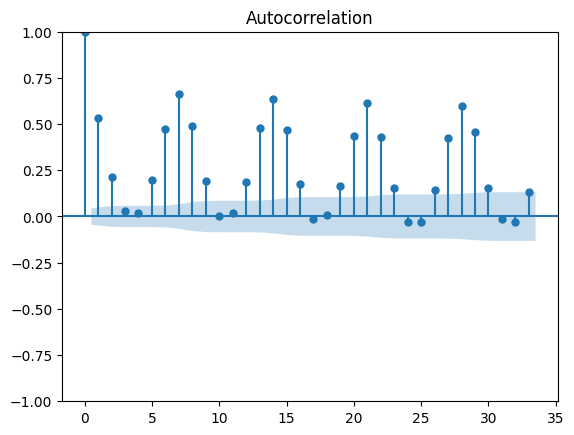

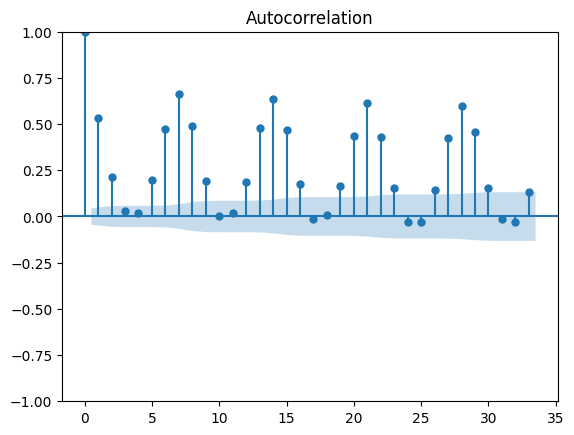

In [294]:
plot_acf(split_matrix(tree_temporal.mY,tree_temporal.dLevels)[1].flatten('F'))

In [44]:
tree_temporal.reconcile('top_down_ph')

# print(np.diag(tree_temporal.mW))
print(tree_temporal.mP.shape)
np.round(tree_temporal.mP,2)

(7, 8)


array([[0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.14, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.17, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

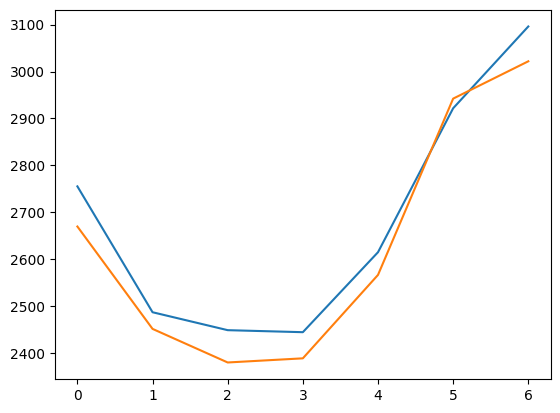

In [63]:
tree_temporal.reconcile('top_down_ph')
plt.plot(tree_temporal.mYhat[1:])
plt.plot(tree_temporal.mYtilde[1:])

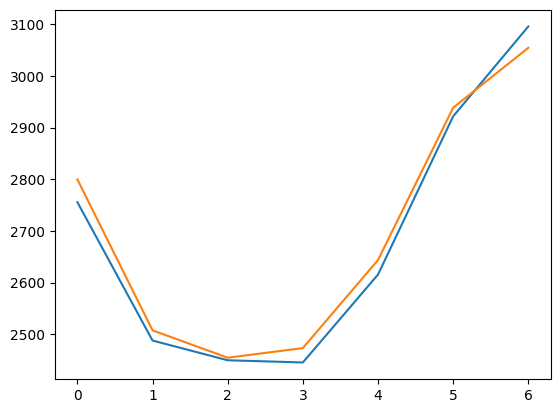

In [64]:
tree_temporal.reconcile('mint_sample')
plt.plot(tree_temporal.mYhat[1:])
plt.plot(tree_temporal.mYtilde[1:])

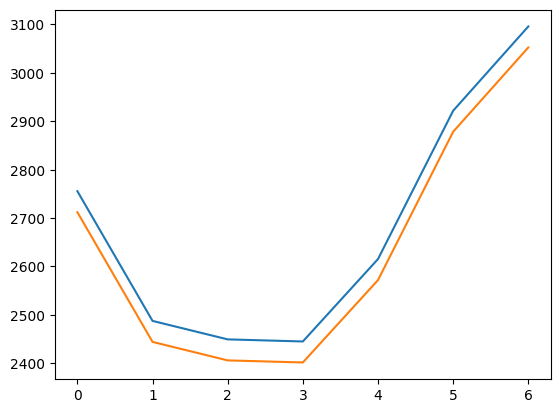

In [67]:
tree_temporal.reconcile('ols')
plt.plot(tree_temporal.mYhat[1:])
plt.plot(tree_temporal.mYtilde[1:])

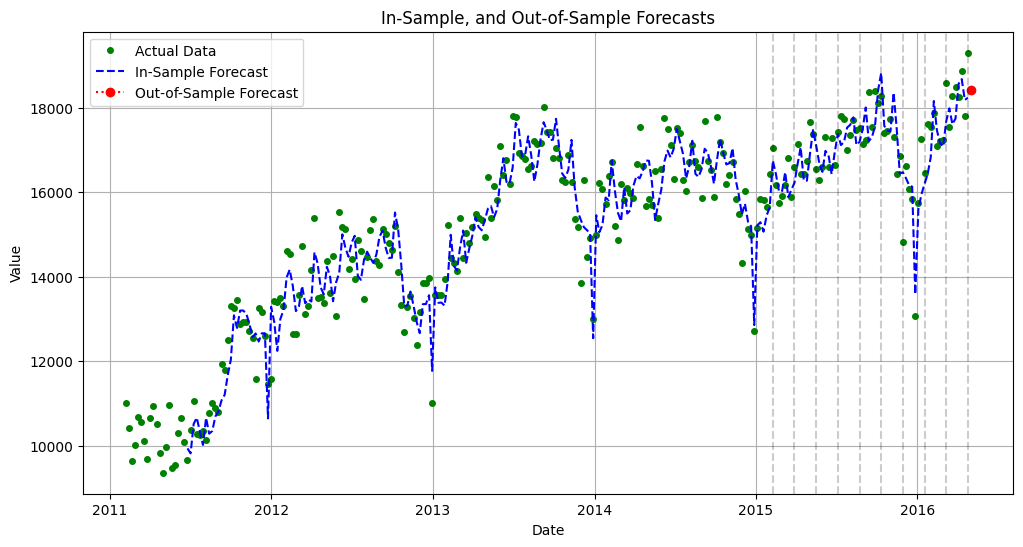

In [65]:
tree_temporal.dForecasters[0].plot_prediction()

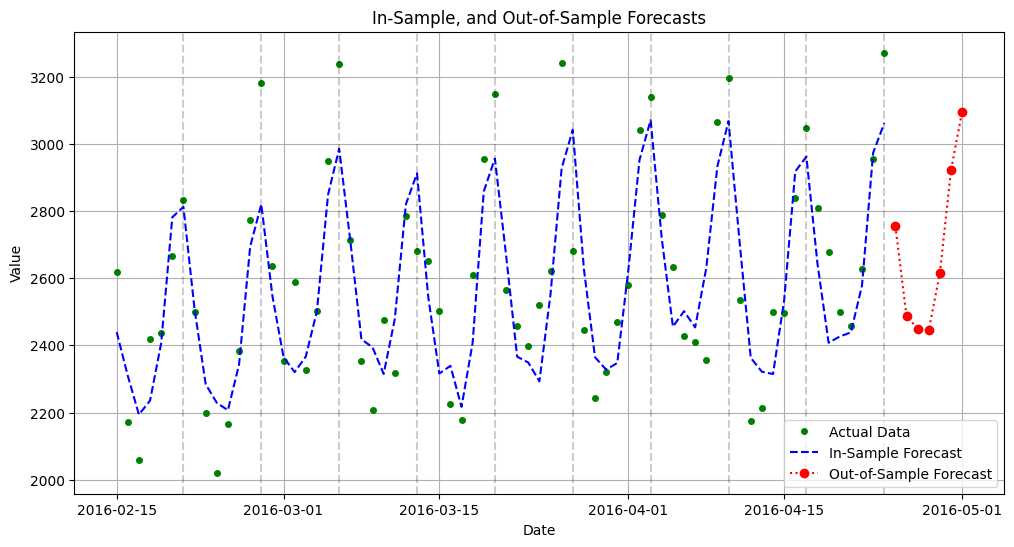

In [66]:
tree_temporal.dForecasters[1].plot_prediction()

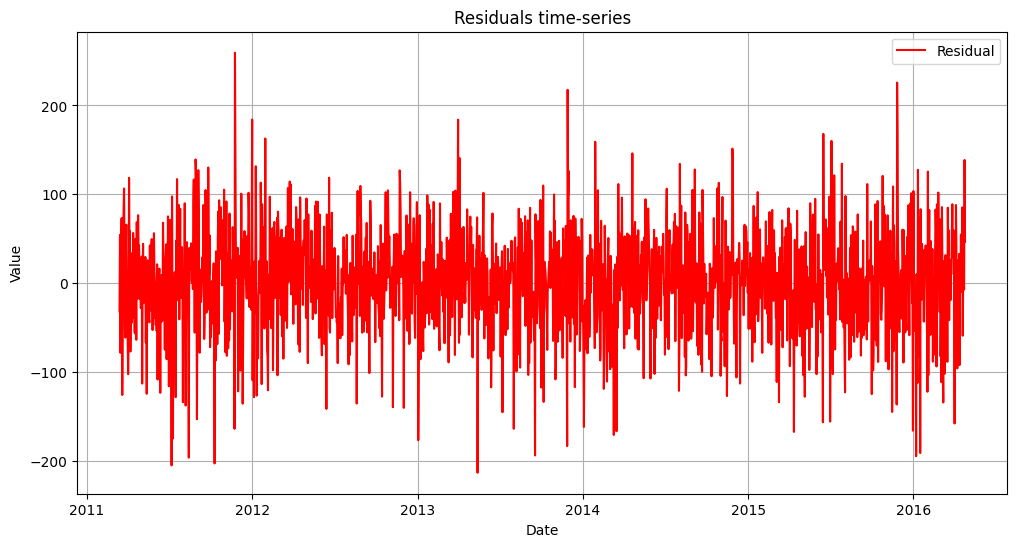

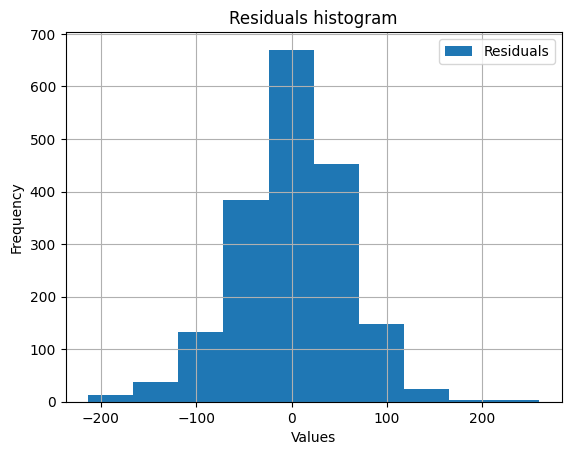

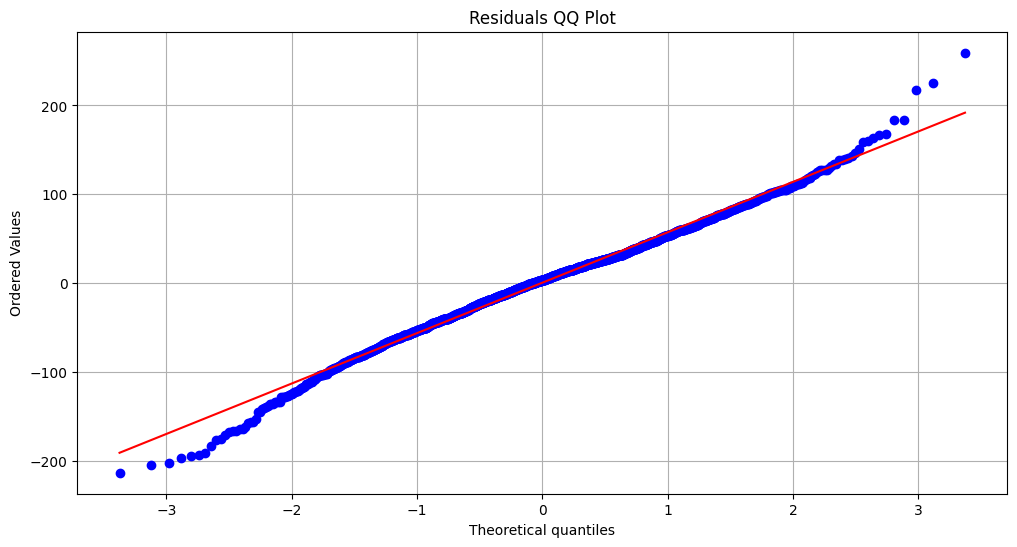

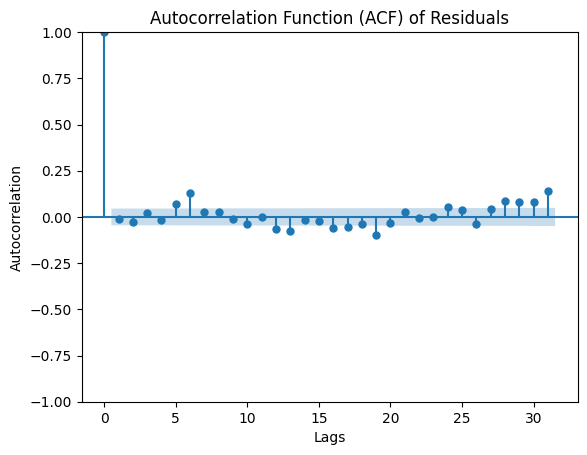

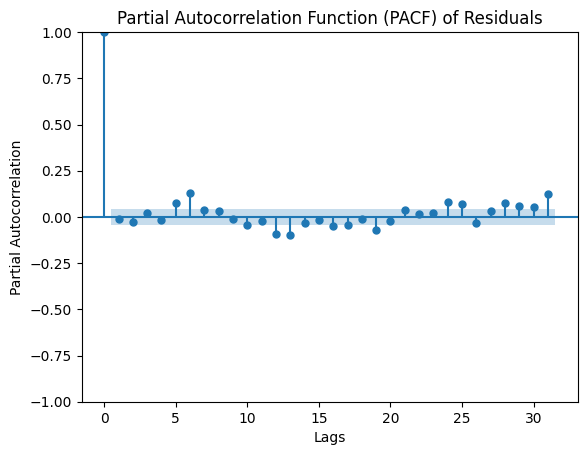

In [21]:
tree_temporal.dForecasters[1].residual_diagnostic()

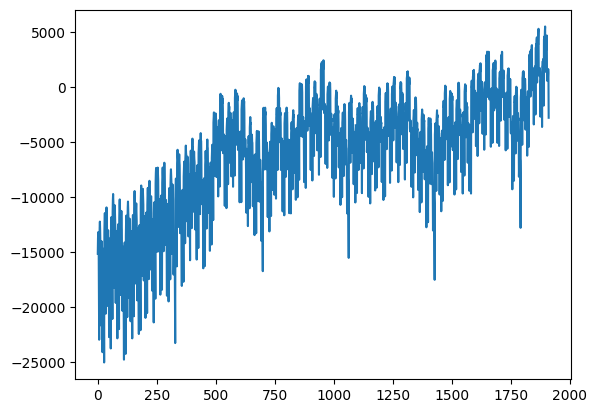

In [95]:
tree_temporal.reconcile('top_down_hp')
plt.plot(tree_temporal.mResRec[1:,:].flatten(order='F'))

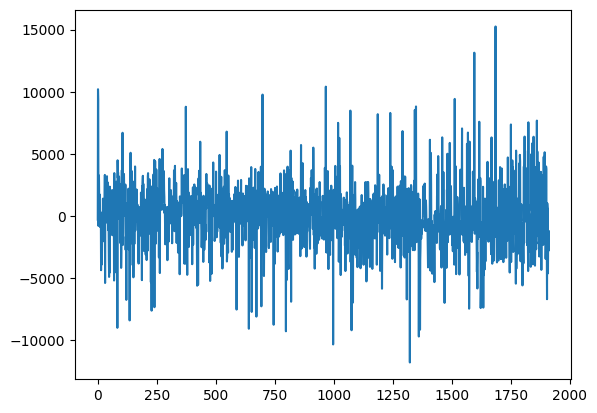

In [81]:
plt.plot(tree_temporal.mRes[1:,:].flatten())

# Cross Validation

for each leaf do temporal reconciliation with certain methods
then visualize the results

In [ ]:
dfPrice=df_price
dfSNAP=df_snap
dfHolidays=df_holidays
dfData=df_data



tree_temporal=Tree(dfData=df[['y']].dropna(), sType='temporal' , iLeaf=i)
tree_temporal.forecast(iOoS=iOoS ,sModel='sarimax', dfHolidays=df[['holidays','christmas']], 
                           dfSNAP=df[['snap']] , 
                           dfPrice=df[['price']], 
                           sTempRecMethod=None)

In [ ]:
transform='log'
# in highest freq
initial=1911-7*10
period=7
horizon=7   
#convert to units of lowest freq
initial=time_converter(initial, from_unit='D' , to_unit='W')
period=time_converter(period, from_unit='D' , to_unit='W')
horizon=time_converter(horizon, from_unit='D' , to_unit='W')  

forecast_method='ucm'
iOoS=7
l_methods_temporal=["bottom_up", "top_down_ph" ,"top_down_hp","wls_svar" , "ols",
                    "wls_acov", "wls_struct" , "wls_hvar" , "mint_sample", "mint_shrink" , "mint_diag"]
dddCVOutputs={}

####################################
dfPrice=df_price
dfSNAP=df_snap
dfHolidays=df_holidays

tree_spatial=Tree(dfData=df_data, sType='spatial')
mYhatIS = np.zeros((tree_spatial.mY.shape[0], tree_spatial.mY.shape[1]))
mRes = np.zeros((tree_spatial.mY.shape[0], tree_spatial.mY.shape[1]))
                        
n=tree_spatial.mY.shape[0]
m=iOoS
tree_spatial.mYhat=np.zeros((n,m))

tree_price=Tree(dfData = dfPrice , sType='spatial')
tree_snap=Tree(dfData = dfSNAP , sType= 'spatial')  


for leaf in  range(tree_spatial.mY.shape[0]):
    ######################
    df=pd.DataFrame(
                    data={'price': tree_price.mY[leaf, :], 'snap': tree_snap.mY[leaf, :]},
                    index=tree_price.date_time_index[:] )
    df.snap=(df.snap!=0).astype(int)

    dfHolidays.loc[(dfHolidays.date.dt.day != 25) & (dfHolidays.date.dt.month != 12), "holidays"] = 1
    dfHolidays.loc[(dfHolidays.date.dt.day == 25) & (dfHolidays.date.dt.month == 12), "christmas"] = 1
    dfHolidays.set_index('date')
    dfHolidays[['holidays','christmas']]=dfHolidays[['holidays','christmas']].fillna(0).astype(int)

    df=pd.merge(df,dfHolidays, left_index=True,  right_on='date', how='left' )
    df=df.fillna(0)
    df[['holidays','christmas']]=df[['holidays','christmas']].astype(int)

    dfY=pd.DataFrame(data=tree_spatial.mY[leaf,:], index=tree_spatial.date_time_index[:] , columns=['y'])
    df.set_index('date',inplace=True)
    df=pd.merge(df,dfY, left_index=True,  right_index=True, how='left' ) 
    ####################
    
    tree_temporal=Tree(dfData=df[['y']].dropna(), sType='temporal' , iLeaf=leaf)
    dddCVOutputs[leaf]=tree_temporal.cross_validation(sTransform="log",
                                                      dfHolidays=df[['holidays','christmas']],
                                                      dfSNAP=df[['snap']] , 
                                                      dfPrice=df[['price']], 
                                                        iInitial=initial,
                                                        iPeriod=period, 
                                                        iHorizon=horizon, 
                                                        lMethods=l_methods_temporal,
                                                        sForecastMethod=forecast_method, sTempRecMethod=None)






c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV folds = 50
Number of CV fol

In [ ]:
with open(os.getcwd()+"\\outputs\\dddCVOutputsTemporal_ucm_log.pkl", "wb") as myFile:
    pickle.dump(dddCVOutputs, myFile)

In [248]:
    
with open(os.getcwd() + "\\outputs\\dddCVOutputsTemporal_sarimax_log.pkl", "rb") as myFile:
    dddCVOutputs = pickle.load(myFile)  # Use pickle.load to read the object    
    
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_ucm.pkl', 'rb') as file:
    ddCVOutputs_spatial_ucm = pickle.load(file) 
    
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet.pkl', 'rb') as file:
    ddCVOutputs_spatial_prophet = pickle.load(file) 

In [ ]:
for method in l_methods_temporal:
    print(return_loss(mTrue=dddCVOutputs[0][method][mYtilde],
                      mPred=dddCVOutputs[0][method][mYtilde],
                      metric='RMSE',
                      slices=tree_temporal.dLevels))
    print(dddCVOutputs[0][method].keys())
    break

dict_keys(['mYtrue', 'mYhat', 'mYtilde', 'mW'])


In [261]:
ddCVOutputs['bottom_up']['mYhat'][:,1]

array([858.38070422, 108.22396435, 119.66892605, 119.93497953,
       113.72460542, 152.30093109, 153.16105312, 140.33526297])

In [ ]:
ddCVOutputs['bottom_up']['mYhat']

array([114.28441385, 108.22396435, 103.22683773, 107.65989079,
       134.51966642, 154.84586432, 138.09102937, 113.22619596,
       108.76608852, 106.66636706, 111.45010115, 139.0836706 ,
       160.15762785, 142.48065593, 115.10553872, 109.45256662,
       112.63696179, 113.28969019, 142.25550507, 170.16410531,
       154.18566471, 126.3220941 , 120.46846497, 116.34588736,
       118.10359742, 143.79138355, 163.7551901 , 145.2132136 ,
       119.63310096, 112.78256813, 107.73228524, 112.43616975,
       139.38350102, 159.0088689 , 142.2079332 , 115.65968623,
       109.92884855, 109.57894315, 112.49566177, 139.63355576,
       162.54746209, 146.07846203, 118.55122344, 111.550598  ,
       108.21965378, 113.80422332, 140.58803783, 160.86084481,
       146.19044393, 122.83234397])

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


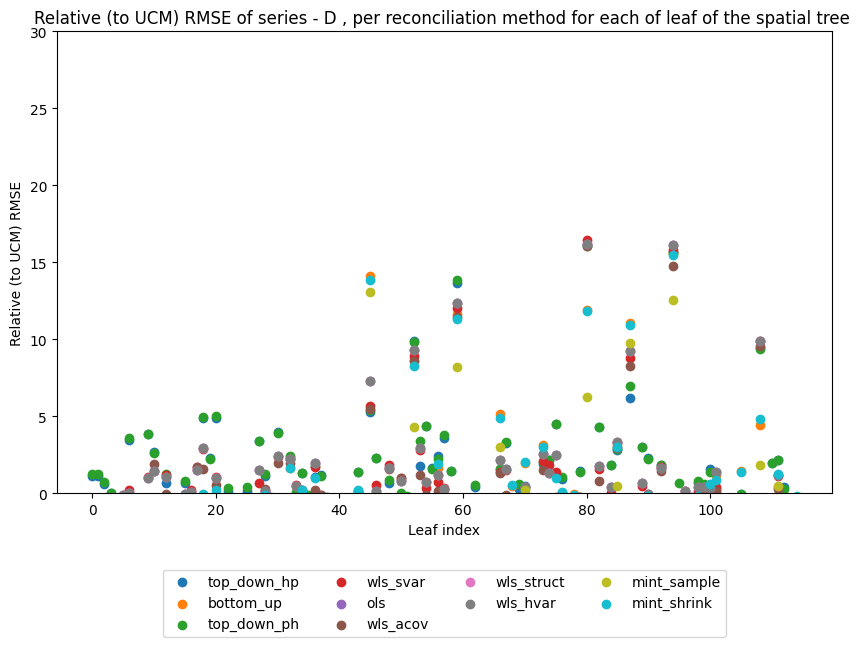

In [267]:
tree=Tree( dfData= df_data , sType='spatial') 
metric='RMSE'
relative='Base'
#relative='top_down_hp'

dfResults_relative=None


for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddCVOutputs=dddCVOutputs[leaf]
        n=ddCVOutputs['bottom_up']['mYhat'].shape[0]
        m=ddCVOutputs['bottom_up']['mYhat'].shape[1]
        for method in l_methods_temporal:
            if method=='mint_diag':
                continue
            
            ddCVOutputs[method]['mYhat'][1:]=ddCVOutputs_spatial_ucm['bottom_up']['mYhat'][leaf].reshape(7,m , order='F' )
        if dfResults_relative is  None:
            dfResults_relative=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddCVOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)
        dfResults_relative=pd.concat([dfResults_relative,pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddCVOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)])
        dfResults_relative.reset_index(drop=True,  inplace=True)
        
    # dfResults.drop(columns=['bottom_up'], inplace=True)    
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_relative.columns:
        plt.scatter(dfResults_relative.index, dfResults_relative[method], label=method)
    plt.xlabel('Leaf index')
    plt.ylim(0,30)
    plt.ylabel(f'Relative (to UCM) {metric}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.title(f'Relative (to UCM) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
    plt.show()


In [279]:
print( str(np.any(dfResults_relative.values>0,axis=1).sum()) + " leafs have increased in accuracy vis a vis UCM from one of reconciliation methods" )

68 leafs have increased in accuracy vis a vis UCM from one of reconciliation methods


c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


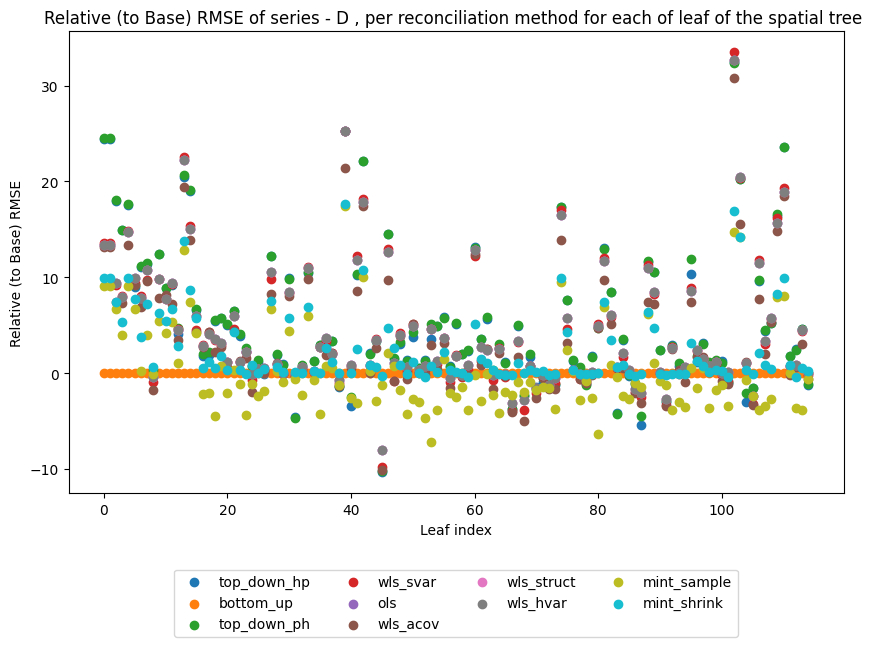

In [ ]:
tree=Tree( dfData= df_data , sType='spatial') 
metric='RMSE'
relative='Base'
#relative='top_down_hp'
dfResults_relative=None


for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddOutputs=dddCVOutputs[leaf]
        if dfResults_relative is  None:
            dfResults_relative=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)
        dfResults_relative=pd.concat([dfResults_relative,pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)])
        dfResults_relative.reset_index(drop=True,  inplace=True)
        
    # dfResults.drop(columns=['bottom_up'], inplace=True)    
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_relative.columns:
        plt.scatter(dfResults_relative.index, dfResults_relative[method], label=method)
    plt.xlabel('Leaf index')
    plt.ylabel(f'Relative (to {relative}) {metric}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.title(f'Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
    plt.show()

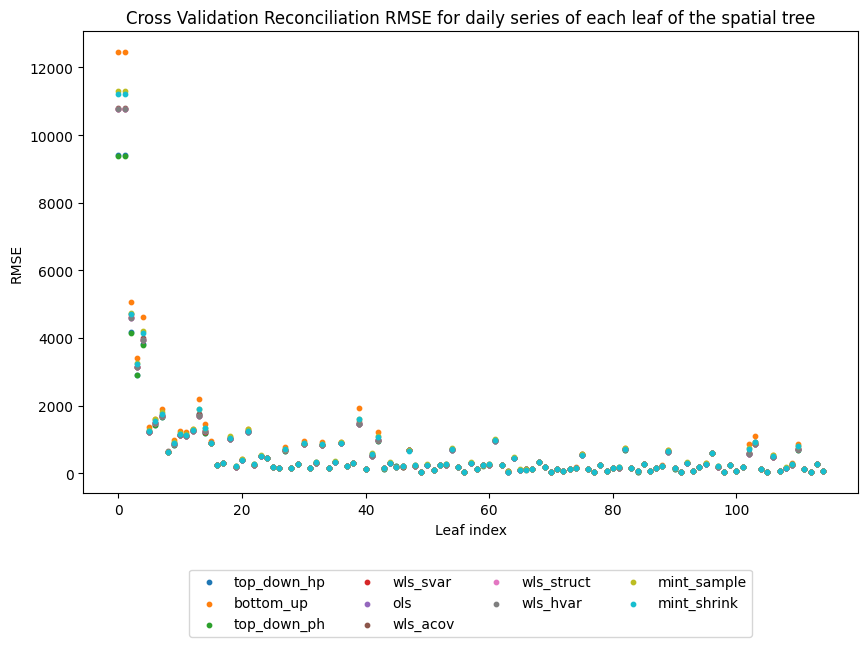

In [215]:
import matplotlib.ticker as ticker

metric='RMSE'
dfResults_absolute=None
for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddOutputs=dddCVOutputs[leaf]
        if dfResults_absolute is  None:
            dfResults_absolute=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , 
                                                         slices=slices , 
                                                         rolling=True, 
                                                         relative=False,
                                                         iters=None).loc[level]).T.reset_index(drop=True)
        dfResults_absolute=pd.concat([dfResults_absolute,pd.DataFrame(data=getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , 
                                                         slices=slices , 
                                                         rolling=True, 
                                                         relative=False,
                                                         iters=None).loc[level]).T.reset_index(drop=True)])
        dfResults_absolute.reset_index(drop=True,  inplace=True)
         
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_absolute.columns:
        plt.scatter(dfResults_absolute.index, dfResults_absolute[method], label=method,s=10)
    plt.xlabel('Leaf index')
    # plt.ylim(0,50)
    plt.ylabel(f'{metric}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.title(f'Cross Validation Reconciliation {metric} for daily series of each leaf of the spatial tree')
    plt.show()

plt.show()

In [ ]:

# UCM hat vs SARIMAX temporal recon tilde
ddOutputs_spatial_temporal_sarimax={}

for method in l_methods_temporal:
    mYtilde=np.zeros((tree_spatial.mY.shape[0],50*7))
    for leaf in range(tree_spatial.mY.shape[0]):
        try:
            mYtilde[leaf,:]=dddCVOutputs[leaf][method]['mYtilde'][1:,:].T.reshape(1,-1)
        except:
            continue

    ddOutputs_spatial_temporal_sarimax[method]={}
    ddOutputs_spatial_temporal_sarimax[method]['mYtilde']=mYtilde
    ddOutputs_spatial_temporal_sarimax[method]['mYhat']=ddCVOutputs_spatial_ucm['bottom_up']['mYhat']
    # ddOutputs_spatial_temporal_sarimax[method]['mYhat']=ddOutputs_spatial_prophet['bottom_up']['mYhat']
    ddOutputs_spatial_temporal_sarimax[method]['mYtrue']=ddCVOutputs_spatial_ucm['bottom_up']['mYtrue']
    
with open(os.getcwd()+"\\outputs\\ddCVOutputs_spatial_temporal_sarimax_log.pkl", "wb") as myFile:
    pickle.dump(ddOutputs_spatial_temporal_sarimax, myFile)

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


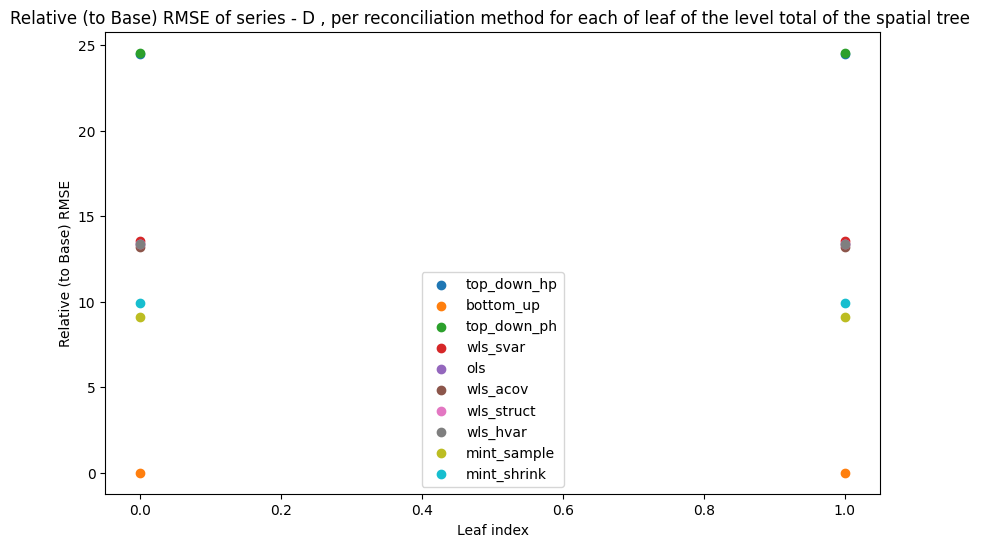

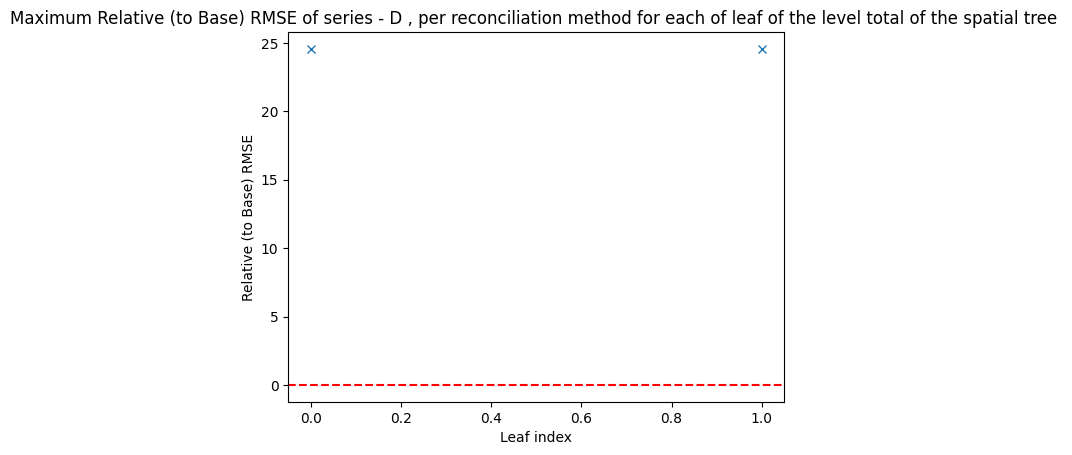

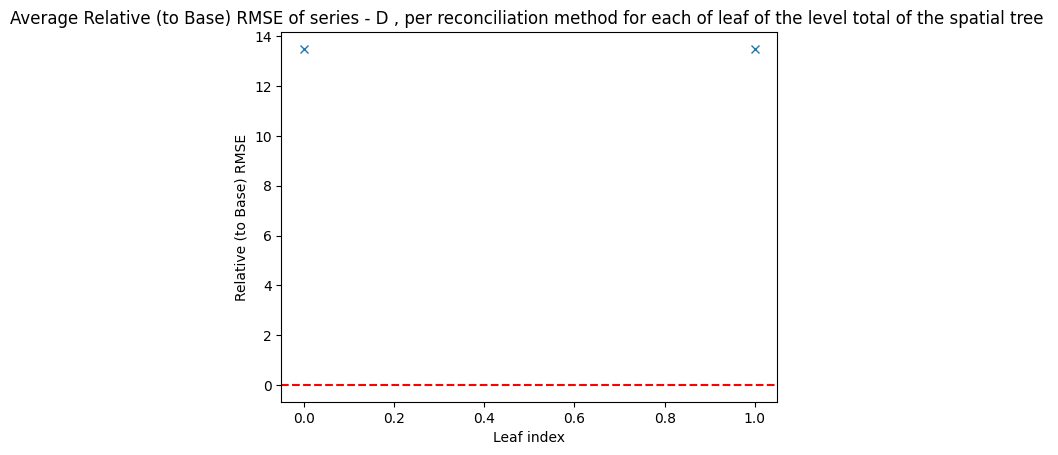

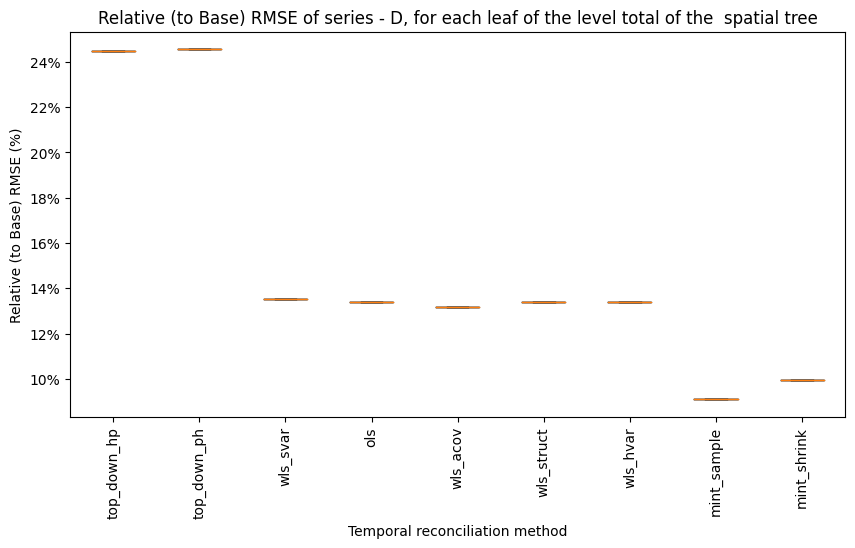

Table of counts the method was highest relative RMSE for level total of the spatial tree
______________________________________
top_down_ph    2
dtype: int64
______________________________________


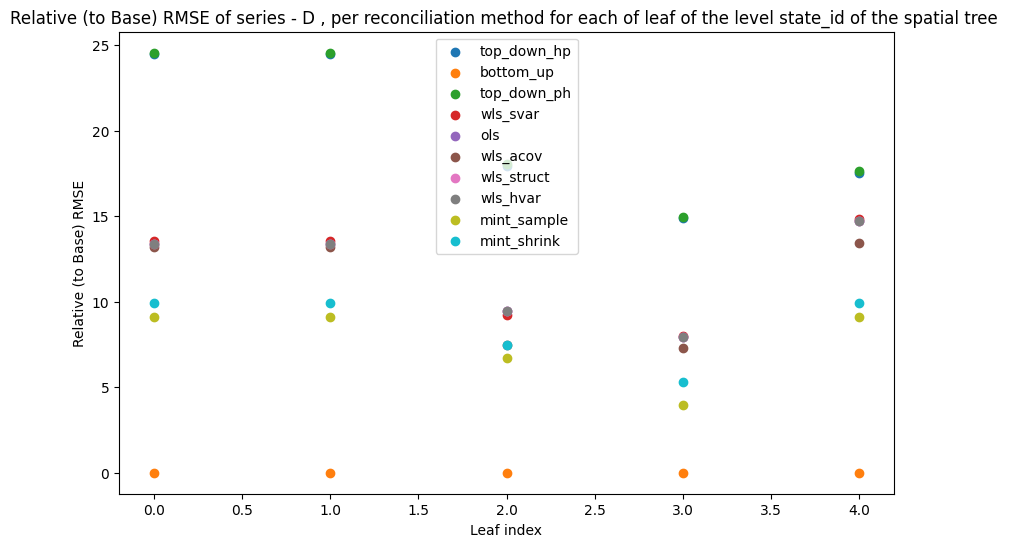

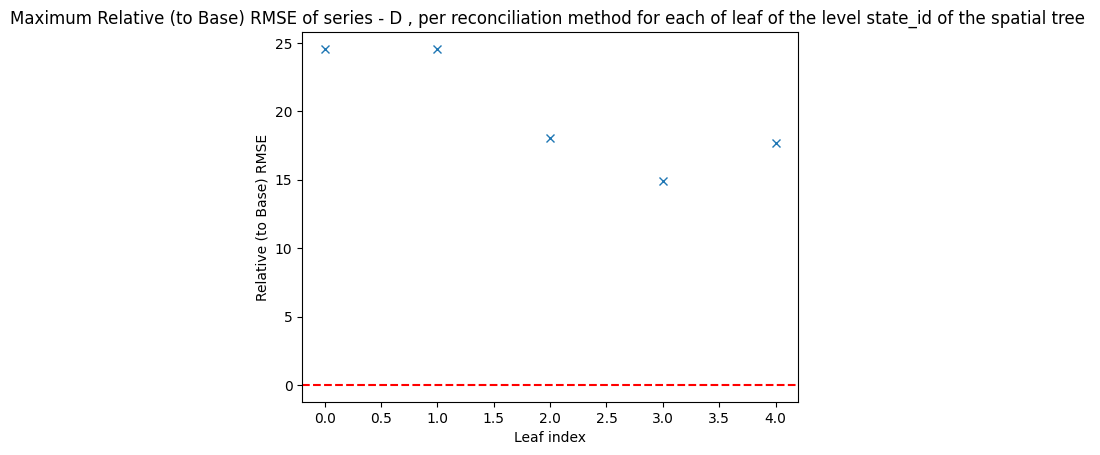

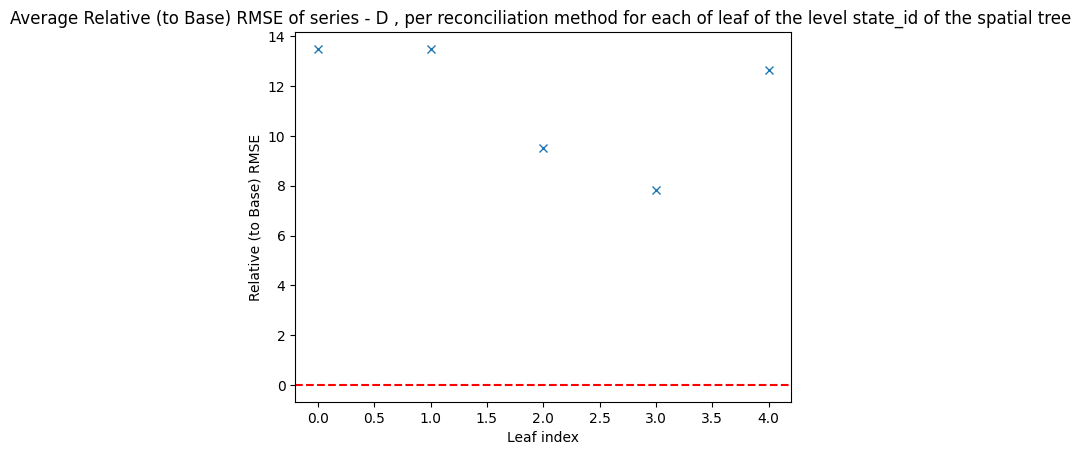

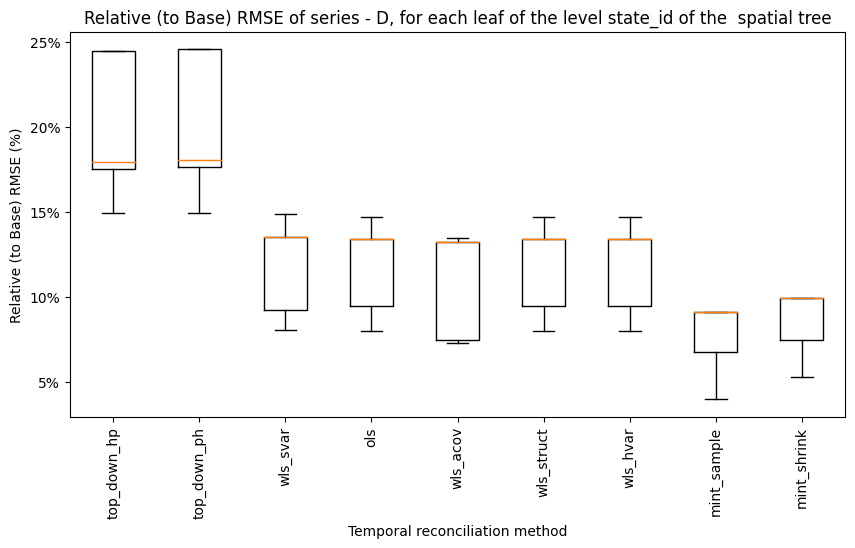

Table of counts the method was highest relative RMSE for level state_id of the spatial tree
______________________________________
top_down_ph    5
dtype: int64
______________________________________


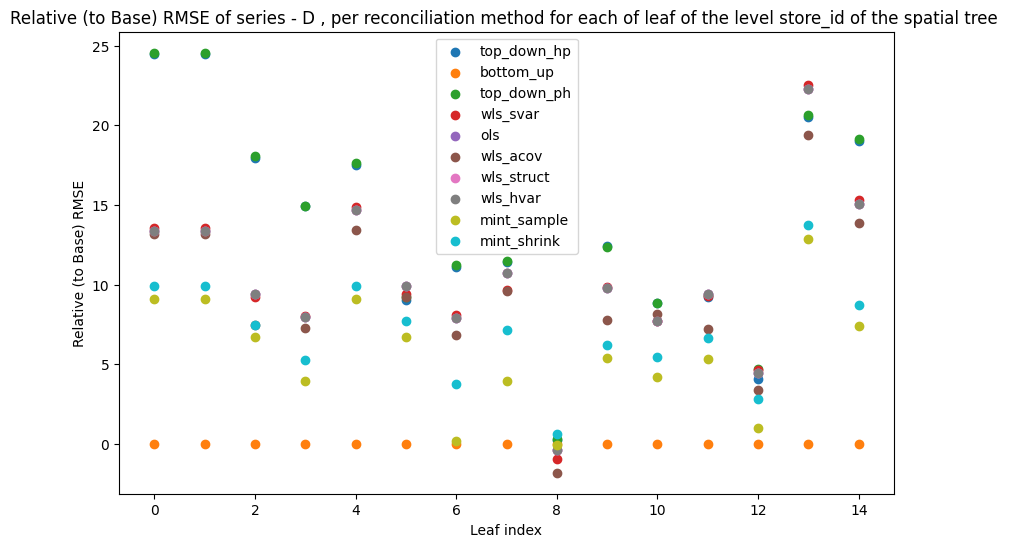

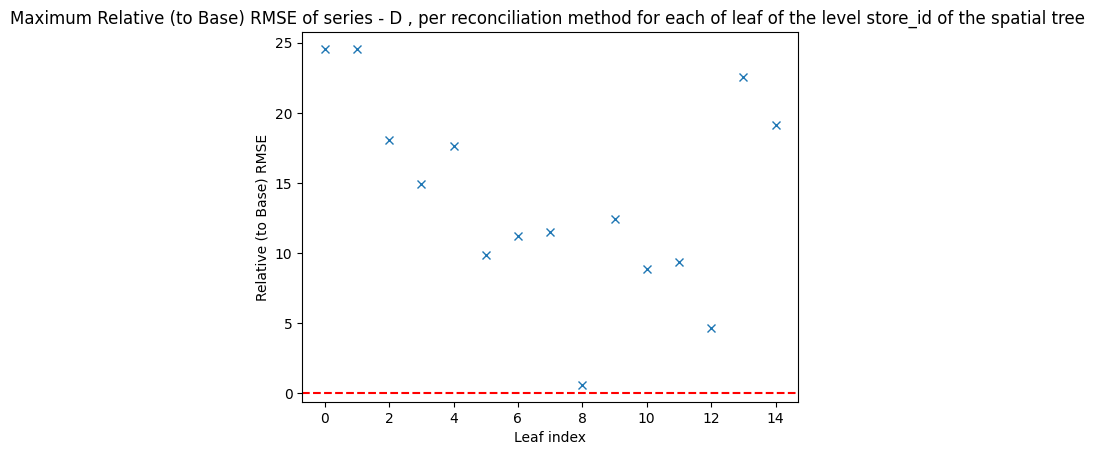

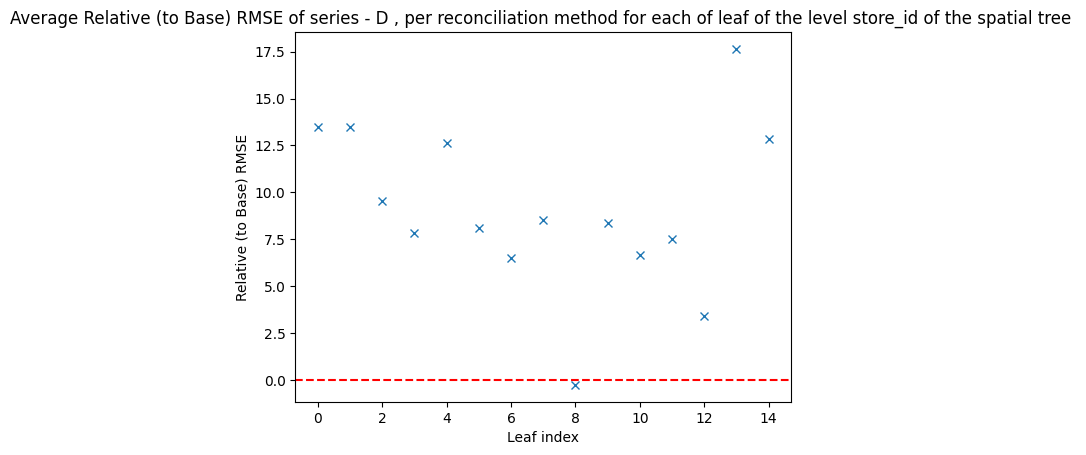

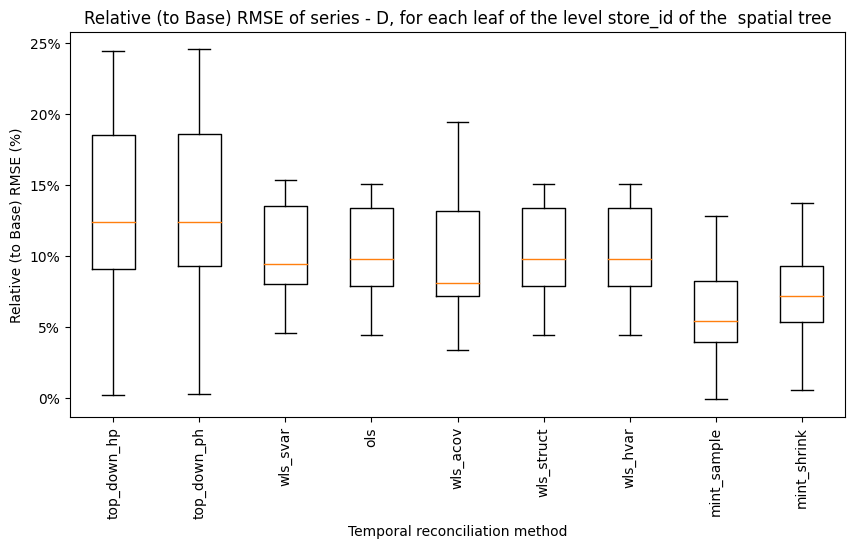

Table of counts the method was highest relative RMSE for level store_id of the spatial tree
______________________________________
mint_shrink    1
ols            2
top_down_hp    2
top_down_ph    9
wls_svar       1
dtype: int64
______________________________________


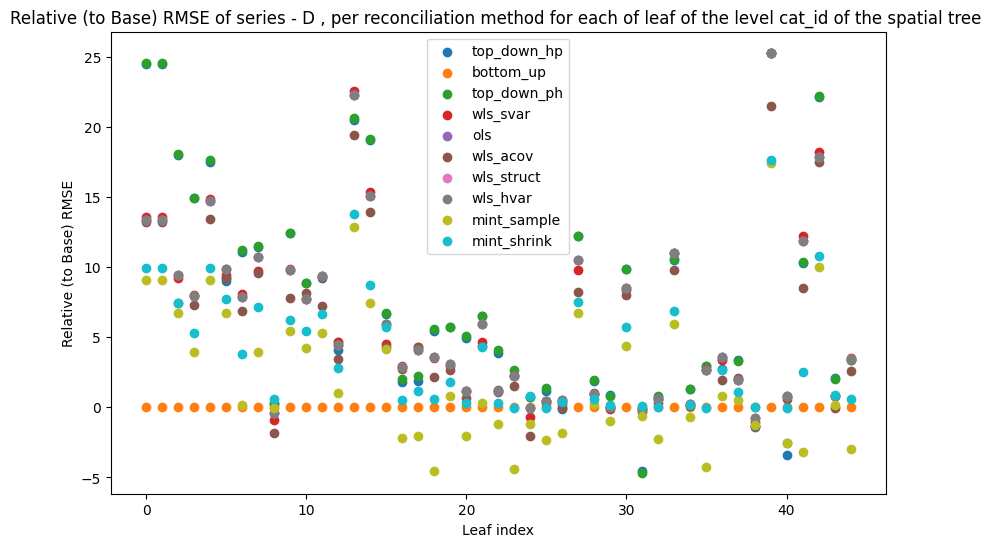

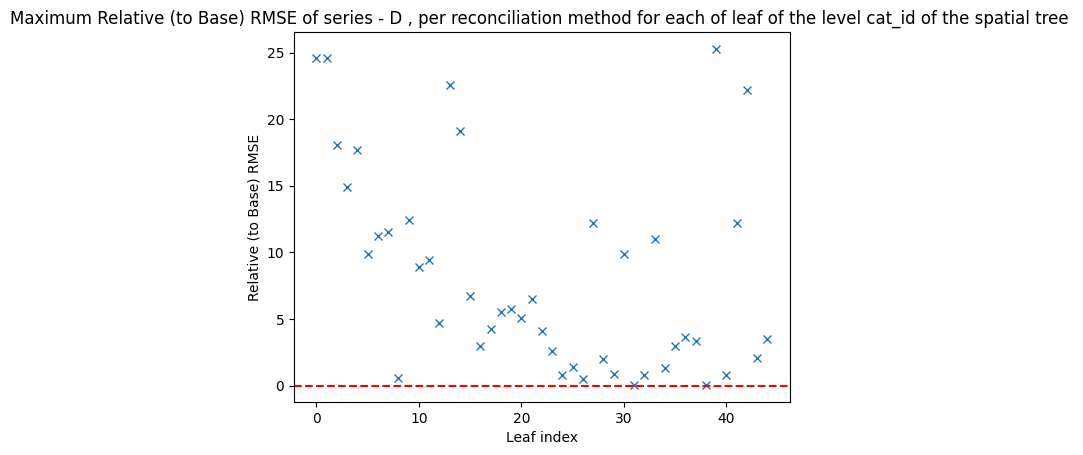

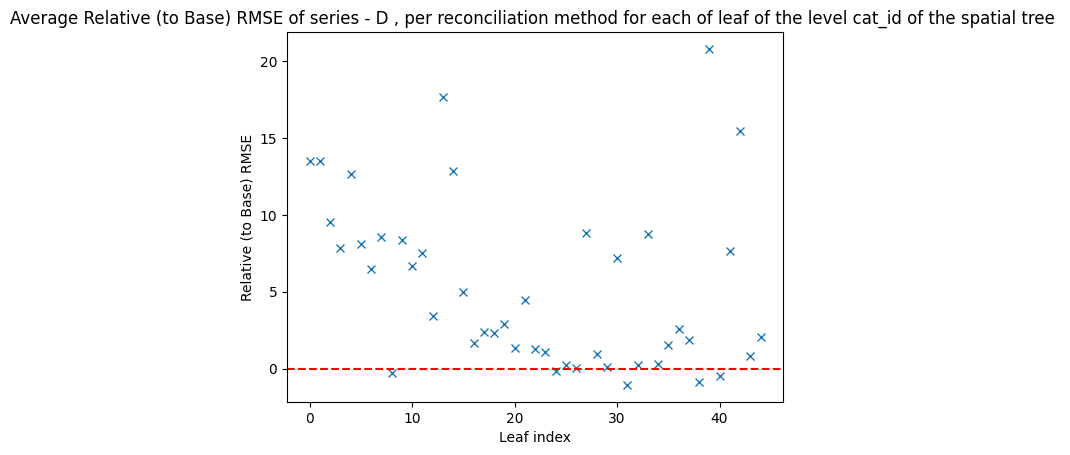

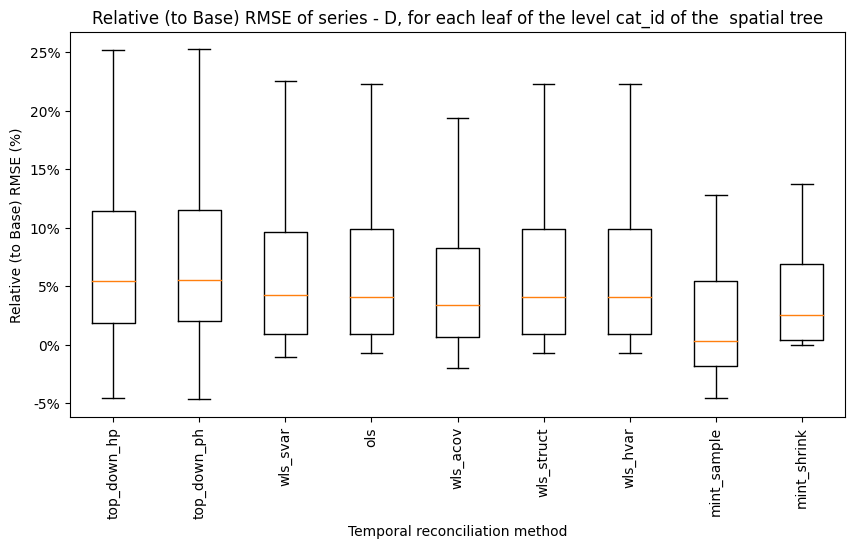

Table of counts the method was highest relative RMSE for level cat_id of the spatial tree
______________________________________
mint_shrink     4
ols             5
top_down_hp     8
top_down_ph    22
wls_acov        1
wls_svar        5
dtype: int64
______________________________________


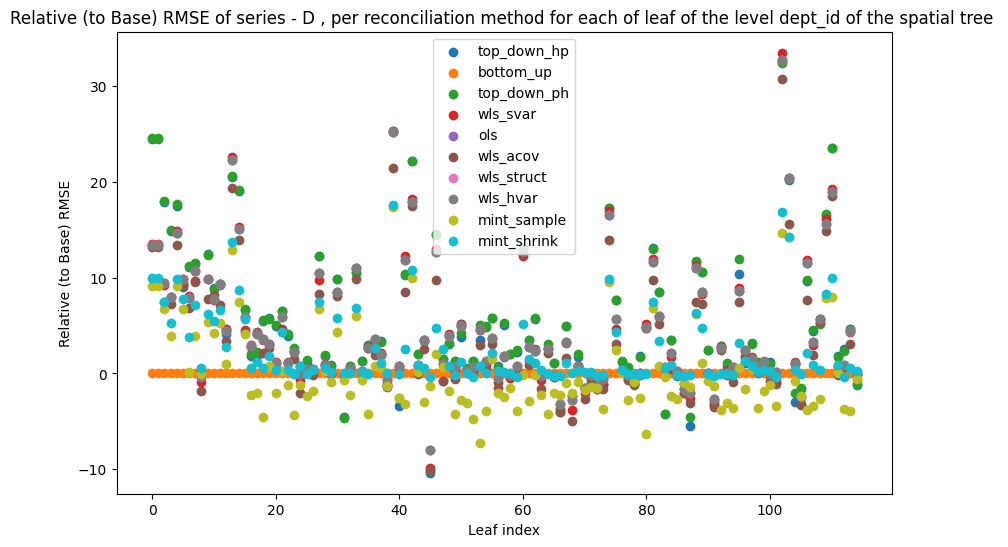

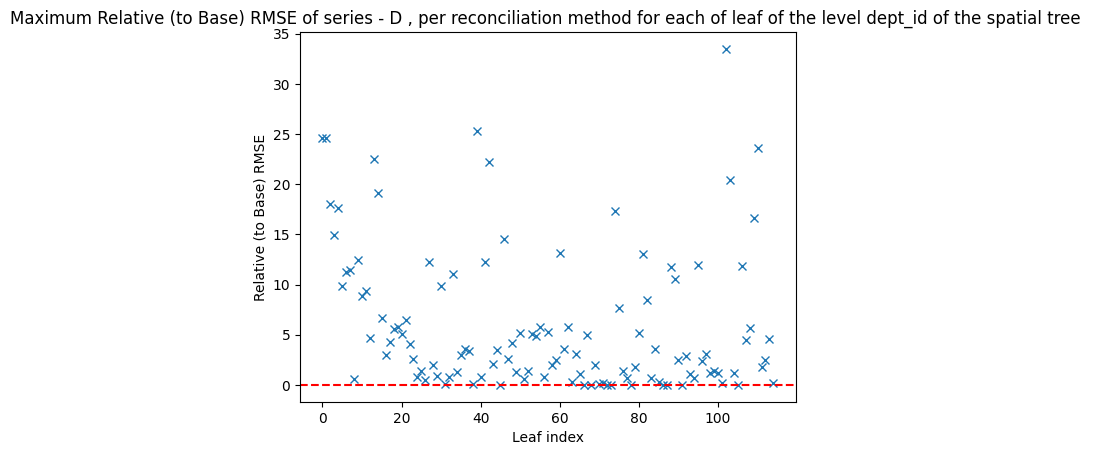

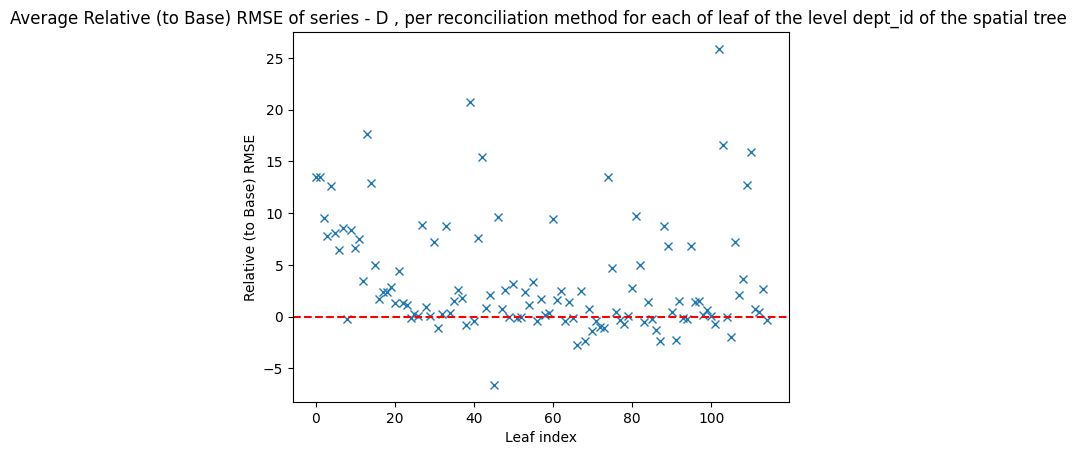

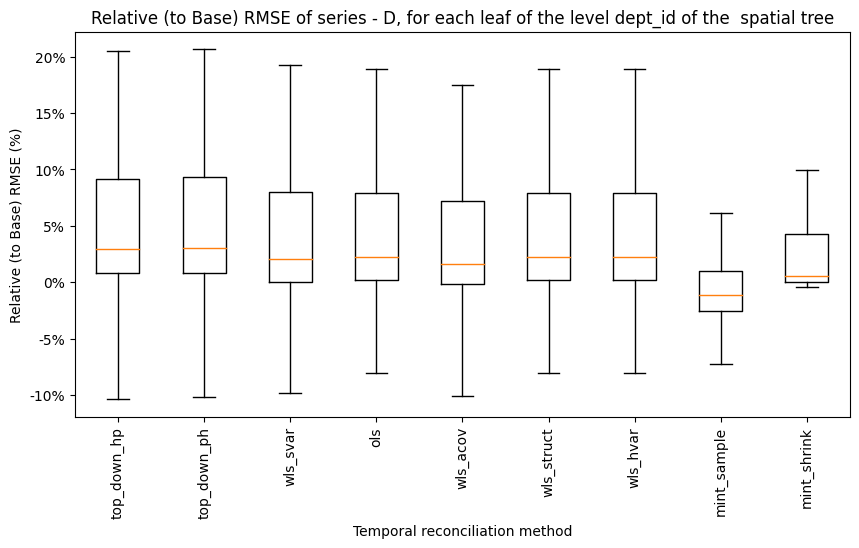

Table of counts the method was highest relative RMSE for level dept_id of the spatial tree
______________________________________
bottom_up       9
mint_shrink    10
ols            12
top_down_hp    28
top_down_ph    44
wls_acov        2
wls_svar       10
dtype: int64
______________________________________


In [138]:
tree=Tree( dfData= df_data , sType='spatial') 
metric='RMSE'
relative='Base'

#relative='top_down_hp'

dfResults_relative=None


for level in ['D']:
    for level_index, spatial_level in enumerate(tree_spatial.dLevels.keys()):

        for  leaf in list(split_dict(dddCVOutputs,tree_spatial.dLevels)[level_index].keys()):
            ddOutputs=dddCVOutputs[leaf]
            if dfResults_relative is  None:
                dfResults_relative=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)
            dfResults_relative=pd.concat([dfResults_relative,pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)])
            dfResults_relative.reset_index(drop=True,  inplace=True)
            
        # dfResults.drop(columns=['bottom_up'], inplace=True)    
        plt.figure(figsize=(10, 6))

        # Scatter plots for each column with the index as x-axis
        for method in dfResults_relative.columns:
            plt.scatter(dfResults_relative.index, dfResults_relative[method], label=method)
        plt.xlabel('Leaf index')
        # plt.ylim(0,50)
        plt.ylabel(f'Relative (to {relative}) {metric}')
        plt.legend()
        plt.title(f'Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the level {spatial_level} of the spatial tree ')
        plt.show()
        
        
        plt.plot(dfResults_relative.T.max(), linestyle='',marker='x')
        plt.axhline(y=0,color='red',linestyle='--')
        plt.xlabel('Leaf index')
        plt.ylabel(f'Relative (to {relative}) {metric}')
        plt.title(f'Maximum Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the level {spatial_level} of the spatial tree ')
        plt.show()


        plt.plot(dfResults_relative.T.mean(), linestyle='',marker='x')
        plt.axhline(y=0,color='red',linestyle='--')
        plt.xlabel('Leaf index')
        plt.ylabel(f'Relative (to {relative}) {metric}')
        plt.title(f'Average Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the level {spatial_level} of the spatial tree ')
        plt.show()





        plt.figure(figsize=(10, 5))  # Adjust height
        plt.boxplot(dfResults_relative.drop(columns=['bottom_up']), labels=dfResults_relative.drop(columns=['bottom_up']).columns, showfliers=False)
        plt.xlabel('Temporal reconciliation method')
        plt.xticks(rotation=90)
        plt.ylabel(f'Relative (to {relative}) {metric} (%)')  # Update label to reflect percentage
        plt.title(f'Relative (to {relative}) {metric} of series - {level}, for each leaf of the level {spatial_level} of the  spatial tree')

        # Format y-axis tick labels as percentages
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

        plt.show()

                
        sr=dfResults_relative.T.idxmax()
        print(f'Table of counts the method was highest relative {metric} for level {spatial_level} of the spatial tree')
        print("______________________________________")
        print(sr.groupby(sr.values).count())
        print("______________________________________")


In [183]:
leaf=0
ddOutputs=dddCVOutputs[leaf]

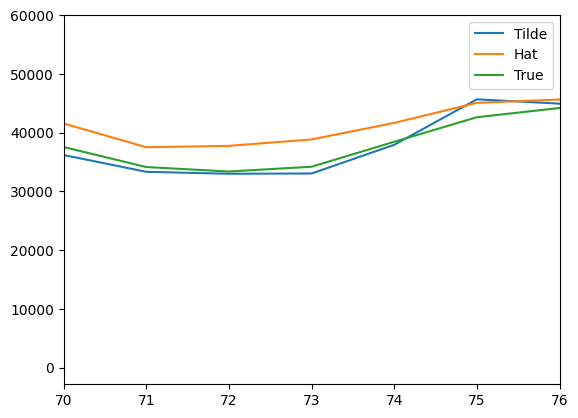

In [187]:
method='top_down_hp'
h=10

plt.plot(ddOutputs[method]['mYtilde'][1:].T.reshape(1,-1)[0], label='Tilde')
plt.plot(ddOutputs[method]['mYhat'][1:].T.reshape(1,-1)[0], label='Hat')
plt.plot(ddOutputs[method]['mYtrue'][1:].T.reshape(1,-1)[0], label='True')
plt.xlim(0+7*h,6+7*h)
plt.legend()
plt.show()

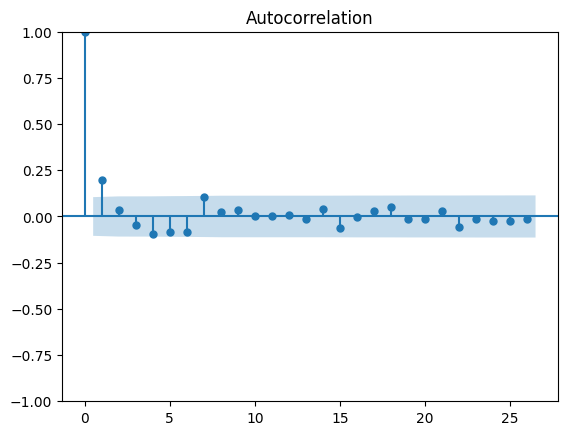

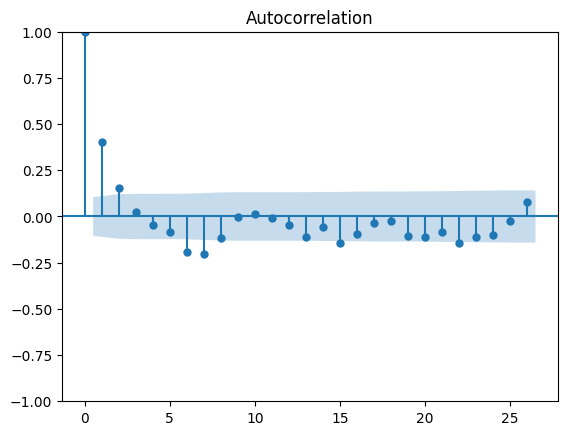

In [188]:

plot_acf((ddOutputs[method]['mYtilde'][1:]-ddOutputs[method]['mYtrue'][1:]).T.reshape(1,-1)[0])
plt.show()
plot_acf((ddOutputs[method]['mYhat'][1:]-ddOutputs[method]['mYtrue'][1:]).T.reshape(1,-1)[0])
plt.show()

In [ ]:
tree=Tree( dfData= df_data , sType='spatial') 
metric='RMSE'
relative='Base'

#relative='top_down_hp'
rec_method='top_down_hp'
vOoSmetric_values=[]


for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddOutputs=dddCVOutputs[leaf]
        
        
        dfResults_relative=pd.concat([dfResults_relative,pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)])
        dfResults_relative.reset_index(drop=True,  inplace=True)
        
    # dfResults.drop(columns=['bottom_up'], inplace=True)    
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_relative.columns:
        plt.scatter(dfResults_relative.index, dfResults_relative[method], label=method)
    plt.xlabel('Leaf index')
    # plt.ylim(0,50)
    plt.ylabel(f'Relative (to {relative}) {metric}')
    plt.legend()
    plt.title(f'Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
    plt.show()
    
    
plt.plot(dfResults_relative.T.max(), linestyle='',marker='x')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Leaf index')
plt.ylabel(f'Relative (to {relative}) {metric}')
plt.title(f'Maximum Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
plt.show()


plt.plot(dfResults_relative.T.mean(), linestyle='',marker='x')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Leaf index')
plt.ylabel(f'Relative (to {relative}) {metric}')
plt.title(f'Average Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
plt.show()



import matplotlib.ticker as ticker

plt.figure(figsize=(10, 5))  # Adjust height
plt.boxplot(dfResults_relative.drop(columns=['bottom_up']), labels=dfResults_relative.drop(columns=['bottom_up']).columns, showfliers=False)
plt.xlabel('Temporal reconciliation method')
plt.xticks(rotation=90)
plt.ylabel(f'Relative (to {relative}) {metric} (%)')  # Update label to reflect percentage
plt.title(f'Relative (to {relative}) {metric} of series - {level}, for each leaf of the spatial tree')

# Format y-axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

plt.show()

        
sr=dfResults_relative.T.idxmax()
print(f'Table of counts the method was highest relative {metric} best in 113 temporal trees')
print("______________________________________")
print(sr.groupby(sr.values).count())
print("______________________________________")


df=dfResults_relative.apply(lambda row: row.where(row == row.max()), axis=1)
for method in dfResults_relative.columns:
    plt.scatter(df.index, df[method], label=method,s=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title(f'Reconciliation method with highest relative {metric} for leaf-i in Cross Validation')
plt.xlabel('Leaf index')
plt.xticks(ticks=df.index[::5], labels=df.index[::5], rotation=90)
plt.axvline(x=0.5,linestyle="--",color='grey')
plt.axvline(x=3.5,linestyle="--",color='grey')
plt.axvline(x=14.5,linestyle="--",color='grey')
plt.axvline(x=44.5,linestyle="--",color='grey')
plt.ylabel(f'Relative (to Base) {metric}')
plt.show()

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


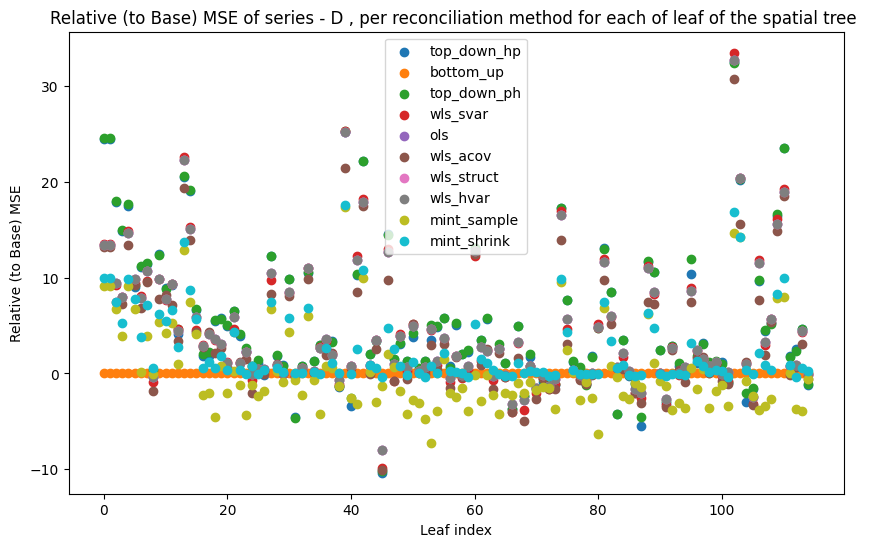

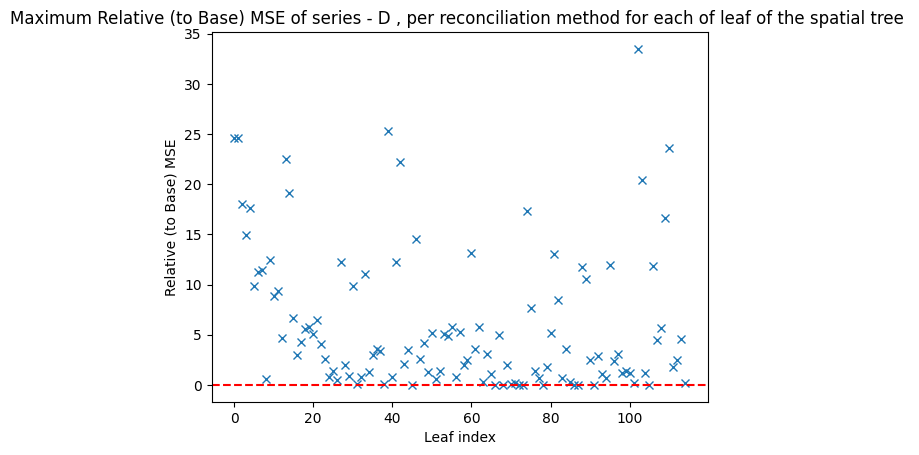

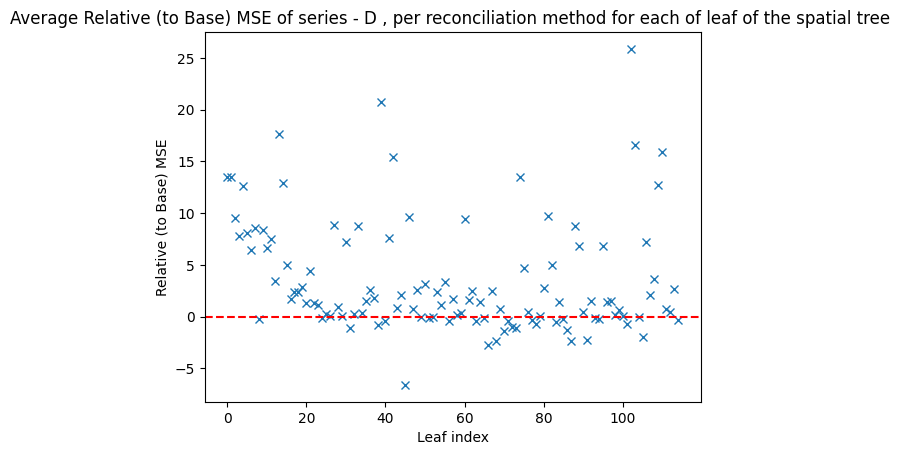

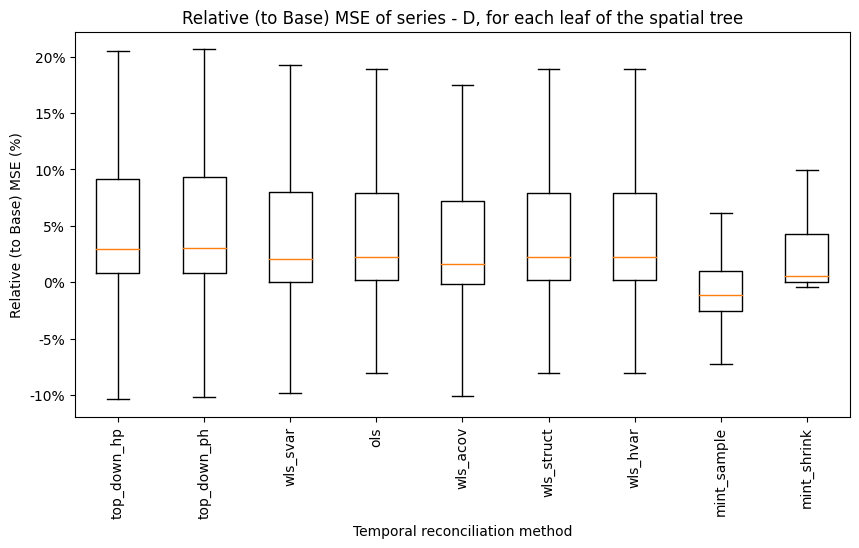

Table of counts the method was highest relative MSE best in 113 temporal trees
______________________________________
bottom_up       9
mint_shrink    10
ols            12
top_down_hp    28
top_down_ph    44
wls_acov        2
wls_svar       10
dtype: int64
______________________________________


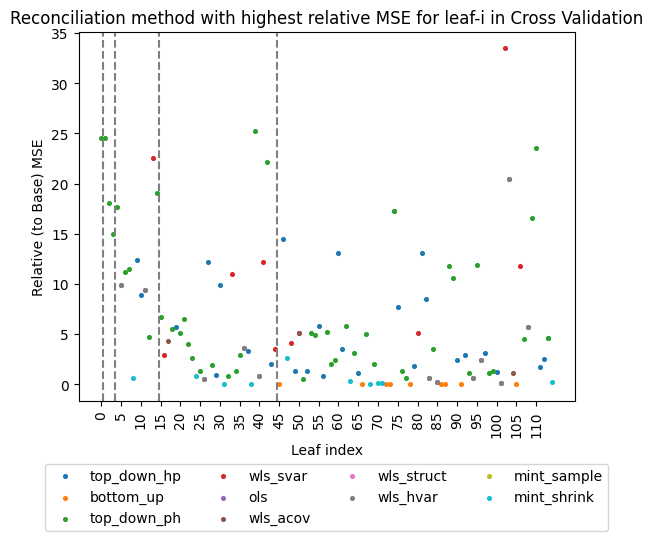

In [ ]:
tree=Tree( dfData= df_data , sType='spatial') 
metric='RMSE'
relative='Base'

#relative='top_down_hp'

dfResults_relative=None


for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddOutputs=dddCVOutputs[leaf]
        if dfResults_relative is  None:
            dfResults_relative=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)
        dfResults_relative=pd.concat([dfResults_relative,pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)])
        dfResults_relative.reset_index(drop=True,  inplace=True)
        
    # dfResults.drop(columns=['bottom_up'], inplace=True)    
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_relative.columns:
        plt.scatter(dfResults_relative.index, dfResults_relative[method], label=method)
    plt.xlabel('Leaf index')
    # plt.ylim(0,50)
    plt.ylabel(f'Relative (to {relative}) {metric}')
    plt.legend()
    plt.title(f'Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
    plt.show()
    
    
plt.plot(dfResults_relative.T.max(), linestyle='',marker='x')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Leaf index')
plt.ylabel(f'Relative (to {relative}) {metric}')
plt.title(f'Maximum Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
plt.show()


plt.plot(dfResults_relative.T.mean(), linestyle='',marker='x')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Leaf index')
plt.ylabel(f'Relative (to {relative}) {metric}')
plt.title(f'Average Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
plt.show()



import matplotlib.ticker as ticker

plt.figure(figsize=(10, 5))  # Adjust height
plt.boxplot(dfResults_relative.drop(columns=['bottom_up']), labels=dfResults_relative.drop(columns=['bottom_up']).columns, showfliers=False)
plt.xlabel('Temporal reconciliation method')
plt.xticks(rotation=90)
plt.ylabel(f'Relative (to {relative}) {metric} (%)')  # Update label to reflect percentage
plt.title(f'Relative (to {relative}) {metric} of series - {level}, for each leaf of the spatial tree')

# Format y-axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

plt.show()

        
sr=dfResults_relative.T.idxmax()
print(f'Table of counts the method was highest relative {metric} best in 113 temporal trees')
print("______________________________________")
print(sr.groupby(sr.values).count())
print("______________________________________")


df=dfResults_relative.apply(lambda row: row.where(row == row.max()), axis=1)
for method in dfResults_relative.columns:
    plt.scatter(df.index, df[method], label=method,s=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title(f'Reconciliation method with highest relative {metric} for leaf-i in Cross Validation')
plt.xlabel('Leaf index')
plt.xticks(ticks=df.index[::5], labels=df.index[::5], rotation=90)
plt.axvline(x=0.5,linestyle="--",color='grey')
plt.axvline(x=3.5,linestyle="--",color='grey')
plt.axvline(x=14.5,linestyle="--",color='grey')
plt.axvline(x=44.5,linestyle="--",color='grey')
plt.ylabel(f'Relative (to Base) {metric}')
plt.show()

In [70]:
dfResults_relative

Method  top_down_hp  bottom_up  top_down_ph  wls_svar    ols  wls_acov  \
0              1.51       0.00         1.65      9.34   9.31      3.42   
1              1.51       0.00         1.65      9.34   9.31      3.42   
2            -20.68       0.00       -19.00    -14.26 -21.16    -14.19   
3             15.79       0.00        15.56     15.17  17.32     15.03   
4            -10.17       0.00       -10.40     -4.94  -5.24     -1.14   
..              ...        ...          ...       ...    ...       ...   
110          -24.63       0.00       -23.14    -14.28 -15.49    -15.46   
111           37.15       0.00        37.19     32.50  32.65     22.80   
112           14.00       0.00        14.84     12.10  18.12    -17.62   
113           -7.05       0.00        -5.78    -26.37 -21.64    -45.83   
114           44.54       0.00        44.07     13.43  11.93     21.32   

Method  wls_struct  wls_hvar  mint_sample  mint_shrink  
0             9.31      9.31         9.34         9.34  
1             9.31      9.31         9.34         9.34  
2           -21.16    -21.16       -24.56       -24.45  
3            17.32     17.32         8.38         8.60  
4            -5.24     -5.24        -9.05        -8.87  
..             ...       ...          ...          ...  
110         -15.49    -15.49       -20.18       -20.06  
111          32.65     32.65        23.37        24.08  
112          18.12     18.12         6.16        10.87  
113         -21.64    -21.64       -20.06       -21.80  
114          11.93     11.93        12.34        12.32  

[115 rows x 10 columns]

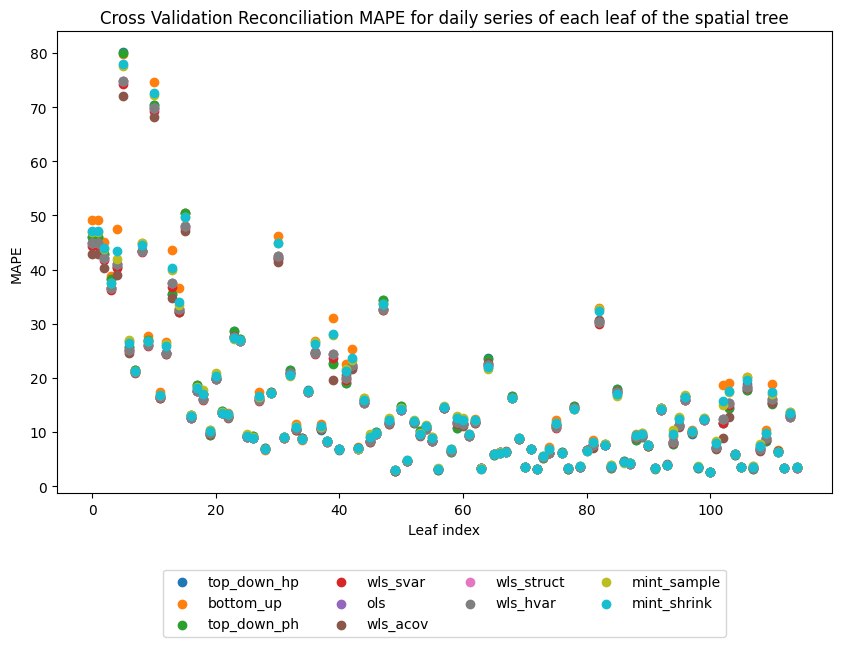

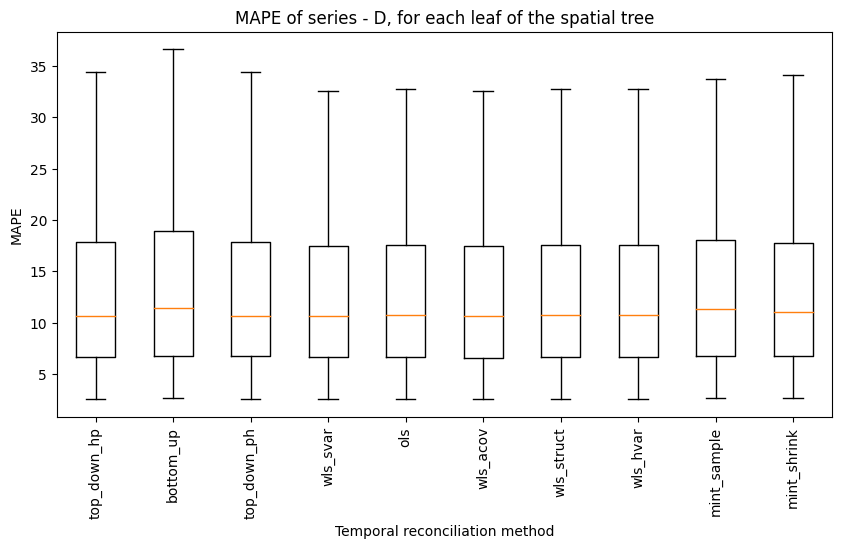

In [123]:
import matplotlib.ticker as ticker

metric='MAPE'
dfResults_absolute=None
for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddOutputs=dddCVOutputs[leaf]
        if dfResults_absolute is  None:
            dfResults_absolute=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , 
                                                         slices=slices , 
                                                         rolling=True, 
                                                         relative=False,
                                                         iters=None).loc[level]).T.reset_index(drop=True)
        dfResults_absolute=pd.concat([dfResults_absolute,pd.DataFrame(data=getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , 
                                                         slices=slices , 
                                                         rolling=True, 
                                                         relative=False,
                                                         iters=None).loc[level]).T.reset_index(drop=True)])
        dfResults_absolute.reset_index(drop=True,  inplace=True)
         
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_absolute.columns:
        plt.scatter(dfResults_absolute.index, dfResults_absolute[method], label=method)
    plt.xlabel('Leaf index')
    # plt.ylim(0,50)
    plt.ylabel(f'{metric}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.title(f'Cross Validation Reconciliation {metric} for daily series of each leaf of the spatial tree')
    plt.show()

plt.figure(figsize=(10, 5))  # Adjust height
plt.boxplot(dfResults_absolute, labels=dfResults_absolute.columns, showfliers=False)
plt.xlabel('Temporal reconciliation method')
plt.xticks(rotation=90)
plt.ylabel(f'{metric}') 
plt.title(f'{metric} of series - {level}, for each leaf of the spatial tree')

# Format y-axis tick labels as percentages

# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

plt.show()

### if weekly series are bad, TD is bad and all methods but bottom-up  are bad. How can we ttell when weekly is bad ? From insample errors. MINT and other WLS methods do  not generalize well

### Temporal reconciliation is better than bottom-up in half of the leafs , with significant improvement. But which method to choose for which leaf?

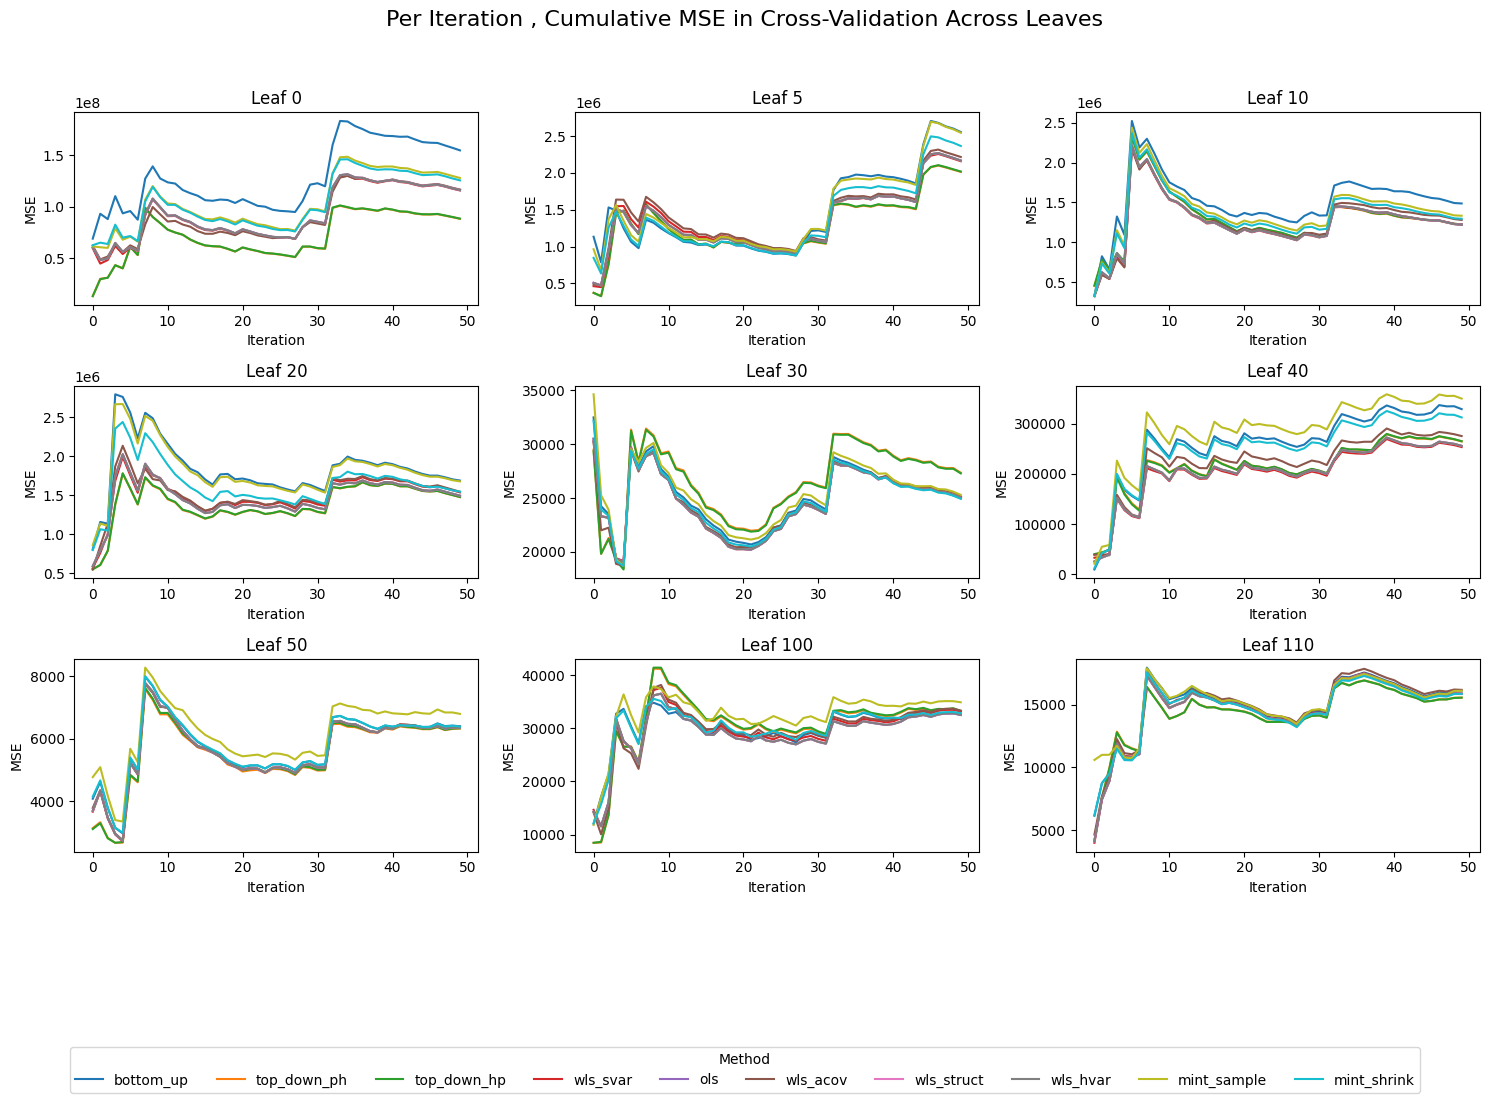

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# List of leaf nodes
leaves = [0, 5, 10, 20 ,30 ,40 , 50, 100, 110]


# Create a 3x3 figure
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easy iteration

# Prepare to collect lines and labels for a single legend
lines = []
labels = []

# Iterate over each leaf and corresponding subplot
for idx, leaf in enumerate(leaves):
    ddOutputs = dddCVOutputs[leaf]

    horizon = 1
    relative = 'Base'
    level = 'D'
    iters = int(ddOutputs['bottom_up']['mYhat'].shape[1] / horizon)
    metric = 'MSE'

    lMethods = list(ddOutputs.keys())

    ax = axes[idx]  # Select subplot
    for method in lMethods:
        vValues = np.zeros(iters)

        for iter in range(1, iters + 1):
            vValues[iter - 1] = getCVResults(
                h=horizon,
                iOoS=horizon,
                ddOutputs=ddOutputs,
                metric=metric,
                slices=[7, 1],
                iters=iter,
                rolling=False,
                relative=False,
            )[method].loc[level]

        vCumAvg = np.cumsum(vValues) / np.arange(1, len(vValues) + 1)
        line, = ax.plot(
            np.arange(iters),
            vCumAvg,
            linestyle="-",
            label=method,
        )
        
        # Collect lines and labels for the shared legend
        if idx == 0:  # Only collect once (from the first subplot)
            lines.append(line)
            labels.append(method)

    ax.set_title(f"Leaf {leaf}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(metric)

# Hide unused subplots if less than 9
for i in range(len(leaves), 9):
    fig.delaxes(axes[i])

# Add a shared legend outside the grid

# Add global title
plt.suptitle("Per Iteration , Cumulative MSE in Cross-Validation Across Leaves", fontsize=16)

# Adjust layout
fig.legend(
    lines,
    labels,
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),  # Move the legend closer to the graphs
    ncol=11,
)

# Adjust layout
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # In # Leave space for the global title and legend
plt.show()


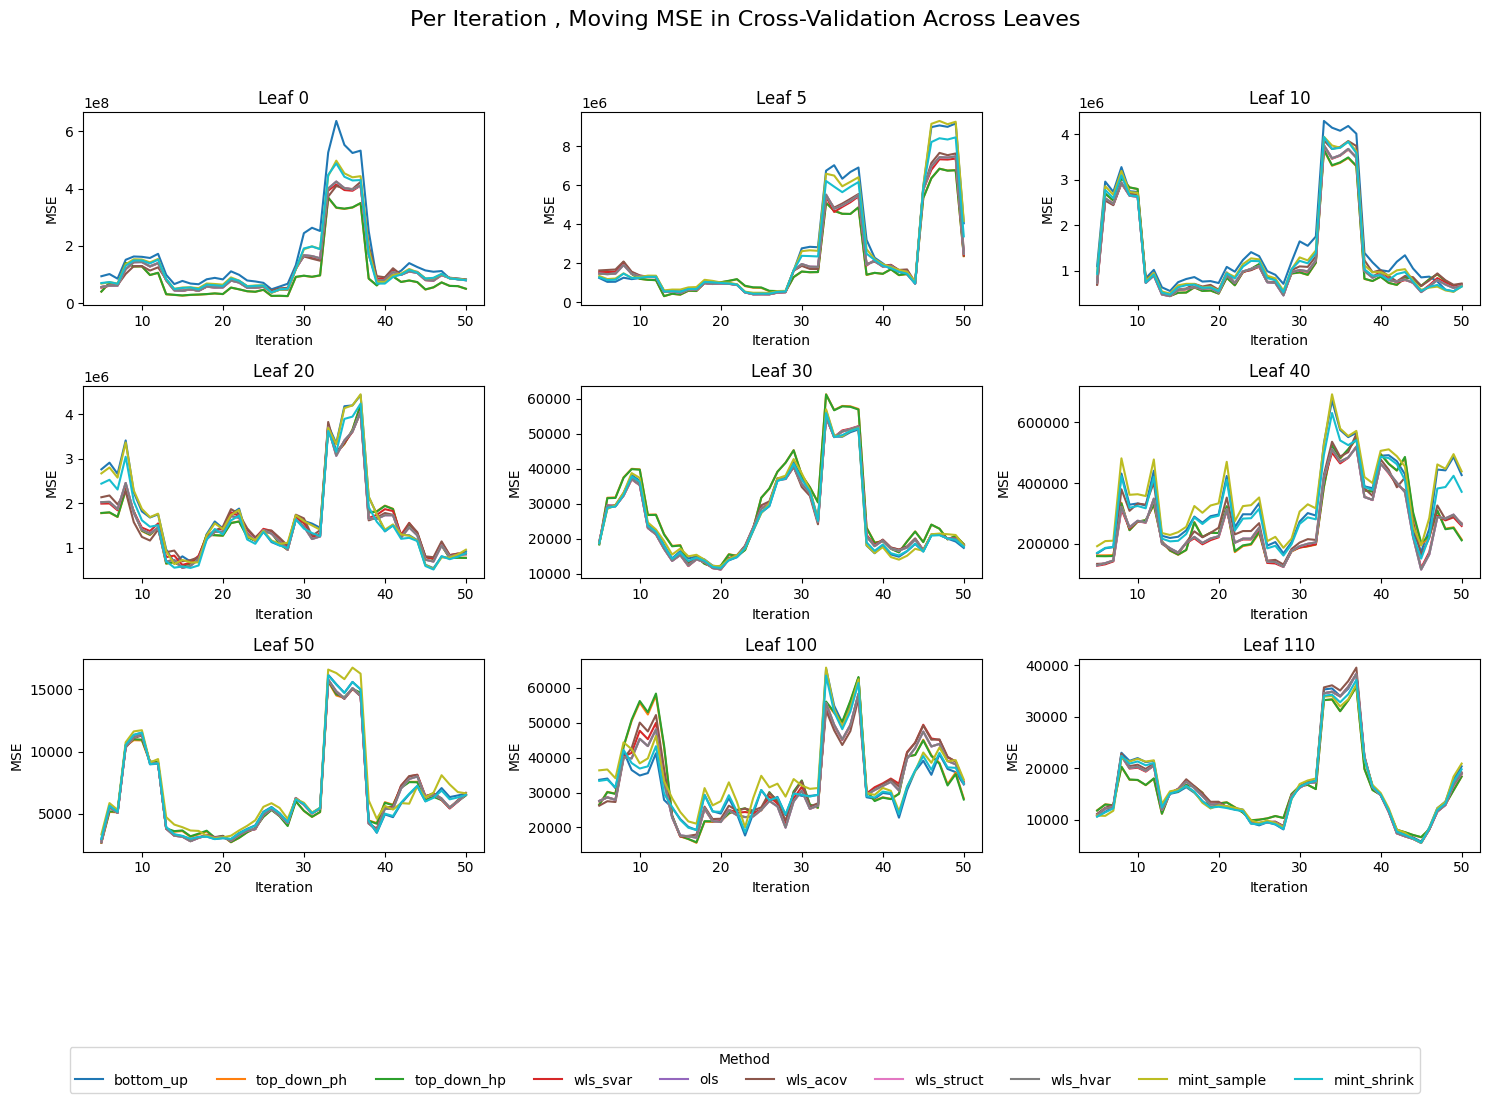

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# List of leaf nodes
leaves = [0, 5, 10, 20, 30, 40, 50, 100, 110]

# Create a 3x3 figure
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easy iteration

# Prepare to collect lines and labels for a single legend
lines = []
labels = []

# Iterate over each leaf and corresponding subplot
for idx, leaf in enumerate(leaves):
    ddOutputs = dddCVOutputs[leaf]

    horizon = 1
    relative = 'Base'
    level = 'D'
    iters = int(ddOutputs['bottom_up']['mYhat'].shape[1] / horizon)
    metric = 'MSE'

    lMethods = list(ddOutputs.keys())

    ax = axes[idx]  # Select subplot
    for method in lMethods:
        vValues = np.zeros(iters)

        for iter in range(1, iters + 1):
            vValues[iter - 1] = getCVResults(
                h=horizon,
                iOoS=horizon,
                ddOutputs=ddOutputs,
                metric=metric,
                slices=[7, 1],
                iters=iter,
                rolling=False,
                relative=False,
            )[method].loc[level]

        # Calculate moving average with window size of 5
        vMovingAvg = np.convolve(vValues, np.ones(5)/5, mode='valid')
        
        # Adjust x-axis to match the length of vMovingAvg
        x_axis = np.arange(5, iters + 1)  # Start from 5 to match the length of vMovingAvg

        line, = ax.plot(
            x_axis,
            vMovingAvg,
            linestyle="-",
            label=method,
        )

        # Collect lines and labels for the shared legend
        if idx == 0:  # Only collect once (from the first subplot)
            lines.append(line)
            labels.append(method)

    ax.set_title(f"Leaf {leaf}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(metric)

# Hide unused subplots if less than 9
for i in range(len(leaves), 9):
    fig.delaxes(axes[i])

# Add a shared legend outside the grid

# Add global title
plt.suptitle("Per Iteration , Moving MSE in Cross-Validation Across Leaves", fontsize=16)

# Adjust layout
fig.legend(
    lines,
    labels,
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),  # Move the legend closer to the graphs
    ncol=11,
)

# Adjust layout
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Leave space for the global title and legend
plt.show()


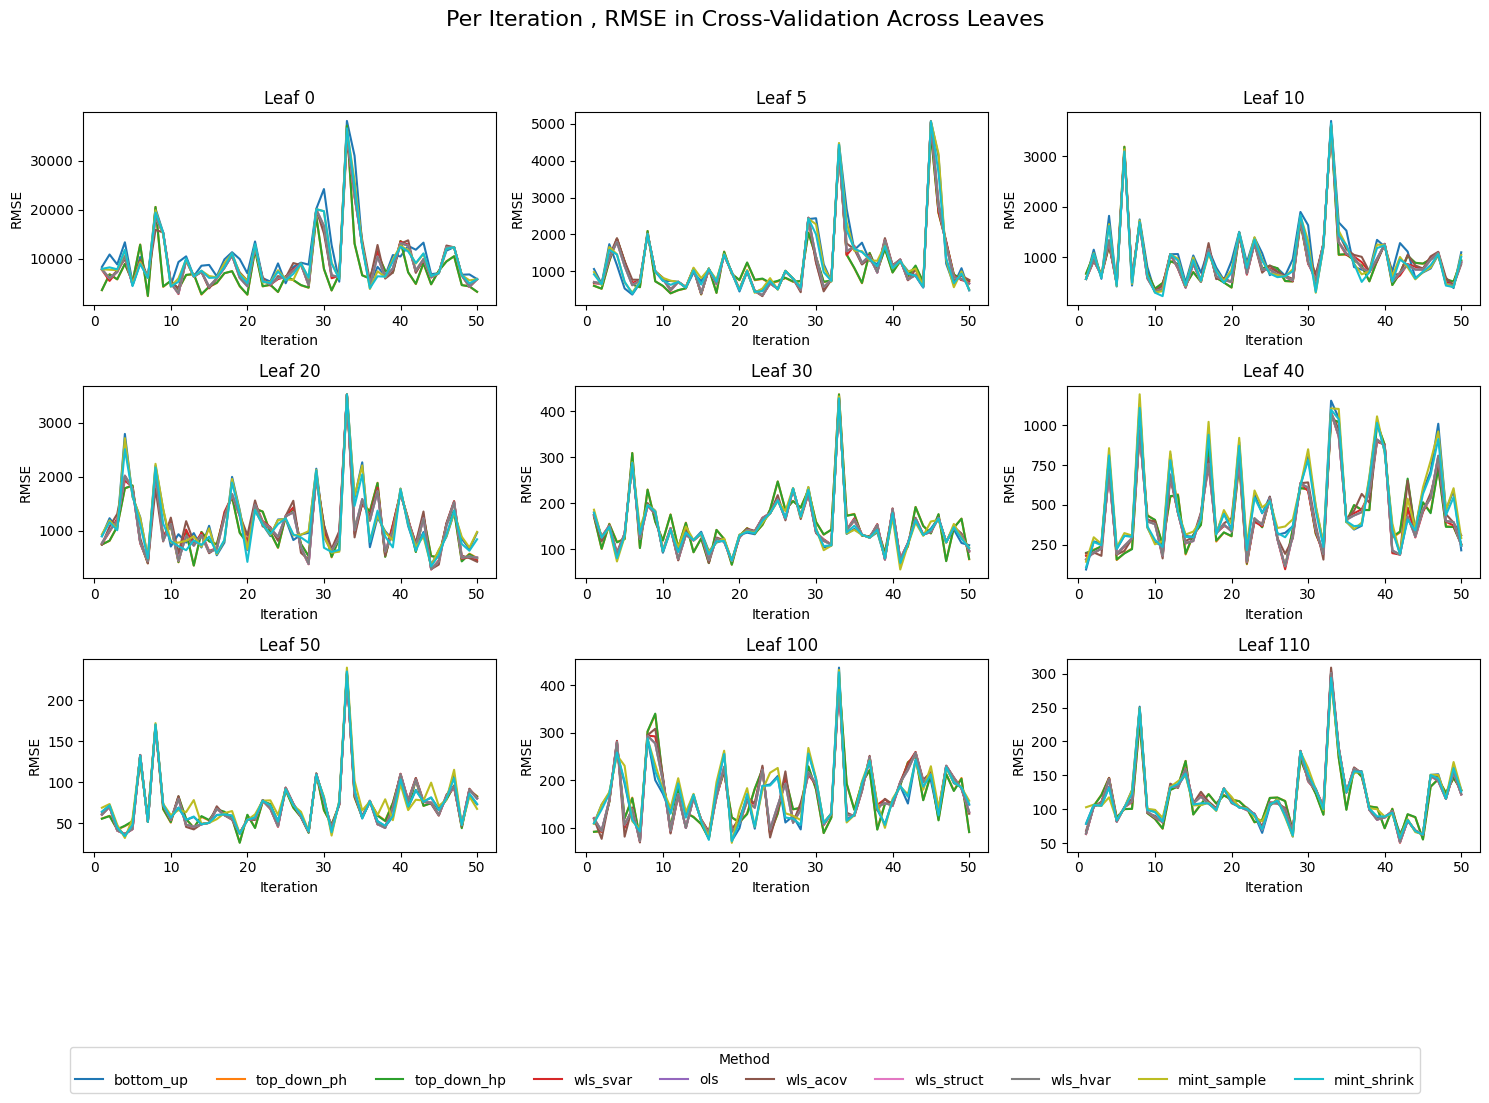

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# List of leaf nodes
leaves = [0, 5, 10, 20, 30, 40, 50, 100, 110]

# Create a 3x3 figure
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easy iteration

# Prepare to collect lines and labels for a single legend
lines = []
labels = []

# Iterate over each leaf and corresponding subplot
for idx, leaf in enumerate(leaves):
    ddOutputs = dddCVOutputs[leaf]

    horizon = 1
    relative = 'Base'
    level = 'D'
    iters = int(ddOutputs['bottom_up']['mYhat'].shape[1] / horizon)
    metric = 'RMSE'

    lMethods = list(ddOutputs.keys())

    ax = axes[idx]  # Select subplot
    for method in lMethods:
        vValues = np.zeros(iters)

        for iter in range(1, iters + 1):
            vValues[iter - 1] = getCVResults(
                h=horizon,
                iOoS=horizon,
                ddOutputs=ddOutputs,
                metric=metric,
                slices=[7, 1],
                iters=iter,
                rolling=False,
                relative=False,
            )[method].loc[level]

        # Calculate moving average with window size of 5
        
        
        # Adjust x-axis to match the length of vMovingAvg
        x_axis = np.arange(1, iters + 1)  # Start from 1 

        line, = ax.plot(
            x_axis,
            vValues,
            linestyle="-",
            label=method,
        )

        # Collect lines and labels for the shared legend
        if idx == 0:  # Only collect once (from the first subplot)
            lines.append(line)
            labels.append(method)

    ax.set_title(f"Leaf {leaf}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(metric)

# Hide unused subplots if less than 9
for i in range(len(leaves), 9):
    fig.delaxes(axes[i])

# Add a shared legend outside the grid

# Add global title
plt.suptitle("Per Iteration , RMSE in Cross-Validation Across Leaves", fontsize=16)

# Adjust layout
fig.legend(
    lines,
    labels,
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),  # Move the legend closer to the graphs
    ncol=11,
)

# Adjust layout
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Leave space for the global title and legend
plt.show()


### Temporal reconciliation does not generalize well, there is a very high variance in which method is the best from week to week

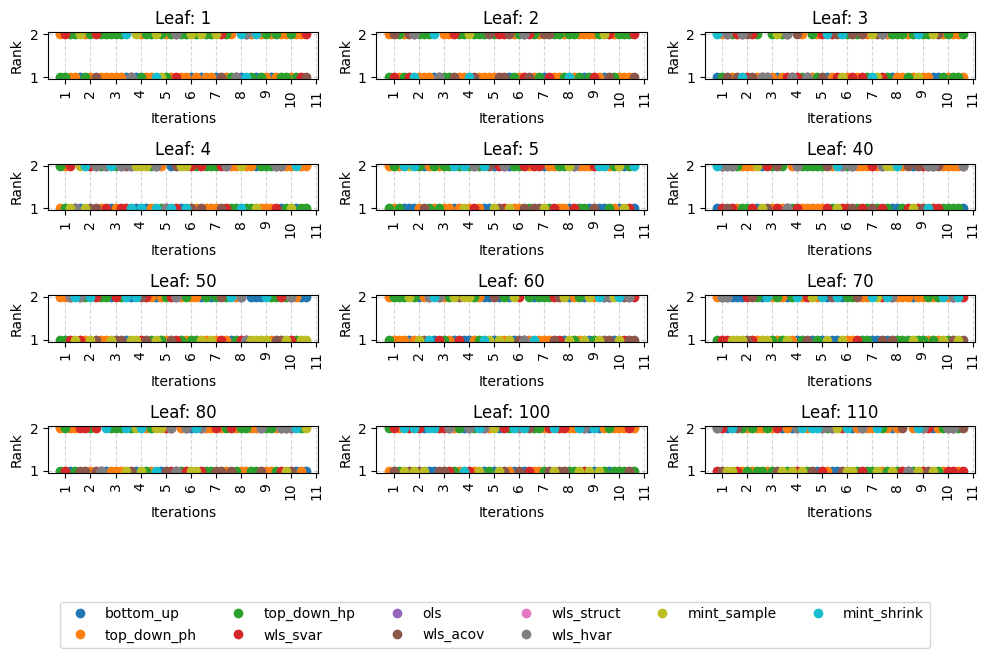

In [127]:
import matplotlib.pyplot as plt
import pandas as pd

leaves = [1, 2, 3, 4, 5, 40, 50, 60 ,70, 80, 100, 110]

# Create a 3x3 grid for subplots, make the plots smaller to reduce white space
fig, axes = plt.subplots(4, 3, figsize=(10, 6))  # Adjusted size to reduce white space
axes = axes.flatten()

for idx, leaf in enumerate(leaves):
    ddOutputs = dddCVOutputs[leaf]

    horizon = 1
    relative = 'Base'
    level = 'D'
    iters = int(ddOutputs['bottom_up']['mYhat'].shape[1] / horizon)
    metric = 'MSE'

    lMethods = list(ddOutputs.keys())
    df_values = pd.DataFrame()

    for method in lMethods:
        for iter in range(1, iters + 1):
            # Populate the DataFrame with results
            df_values.loc[method, str(iter)] = getCVResults(
                h=horizon,
                iOoS=horizon,
                ddOutputs=ddOutputs,
                metric=metric,
                slices=[7, 1],
                iters=iter,
                rolling=False,
                relative=False,
            )[method].loc[level]

    # Rank values column-wise
    df_values = df_values.rank(method='min', axis=0)
    
    # Transpose and filter ranks < 3, then plot as dots
    df_to_plot = df_values[df_values < 3].T
    ax = axes[idx]
    for method in df_to_plot.columns:
        ax.plot(
            df_to_plot.index, df_to_plot[method], 'o', label=method if idx == 0 else ""
        )

    # Customize subplot
    ax.set_title(f"Leaf: {leaf}")
    ax.set_yticks([1, 2])  # Show only y-ticks 1 and 2
    ax.set_ylabel("Rank")
    ax.set_xlabel("Iterations")
    ax.grid(True, linestyle='--', alpha=0.5)

    # Rotate x-axis labels 90 degrees and limit the number of ticks
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xticks(np.arange(1, 52, 5))  # Adjust tick spacing

# Remove any unused subplots (if less than 9 leaves)
for extra_ax in axes[len(leaves):]:
    fig.delaxes(extra_ax)

# Add a single legend outside the grid (only once)
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = dict(zip(labels, handles))
fig.legend(
    unique_handles_labels.values(),
    unique_handles_labels.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=6,
)

# Adjust layout and show the plot, tighten layout further to reduce white space
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.show()


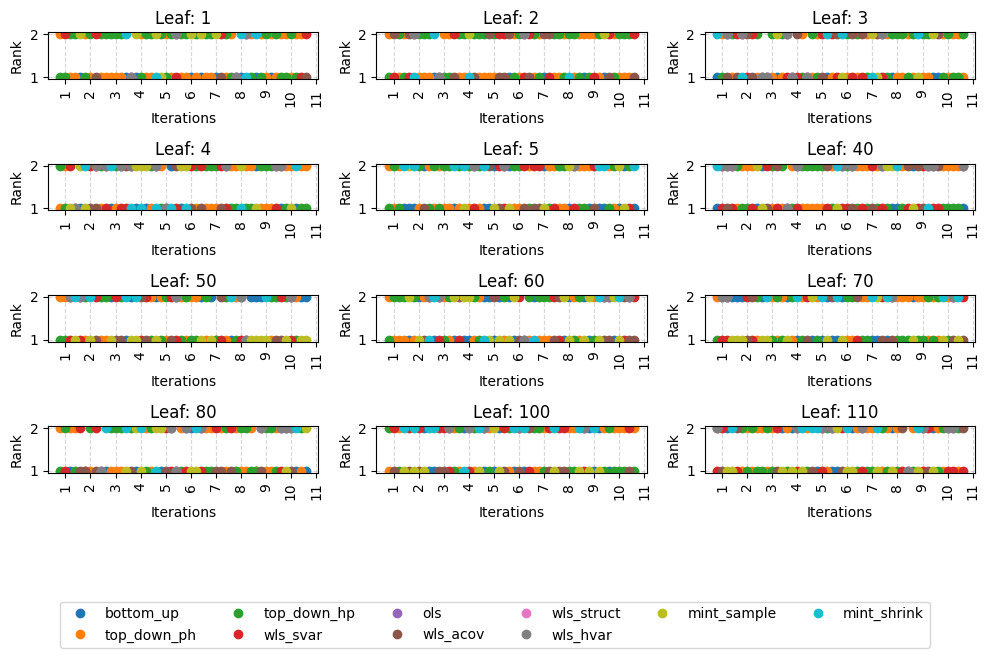

In [128]:
import matplotlib.pyplot as plt
import pandas as pd

leaves = [1, 2, 3, 4, 5, 40, 50, 60 ,70, 80, 100, 110]

# Create a 3x3 grid for subplots, make the plots smaller to reduce white space
fig, axes = plt.subplots(4, 3, figsize=(10, 6))  # Adjusted size to reduce white space
axes = axes.flatten()

for idx, leaf in enumerate(leaves):
    ddOutputs = dddCVOutputs[leaf]

    horizon = 1
    relative = 'Base'
    level = 'D'
    iters = int(ddOutputs['bottom_up']['mYhat'].shape[1] / horizon)
    metric = 'RMSE'

    lMethods = list(ddOutputs.keys())
    df_values = pd.DataFrame()

    for method in lMethods:
        for iter in range(1, iters + 1):
            # Populate the DataFrame with results
            df_values.loc[method, str(iter)] = getCVResults(
                h=horizon,
                iOoS=horizon,
                ddOutputs=ddOutputs,
                metric=metric,
                slices=[7, 1],
                iters=iter,
                rolling=False,
                relative=False,
            )[method].loc[level]

    # Rank values column-wise
    df_values = df_values.rank(method='min', axis=0)
    
    # Transpose and filter ranks < 3, then plot as dots
    df_to_plot = df_values[df_values < 3].T
    ax = axes[idx]
    for method in df_to_plot.columns:
        ax.plot(
            df_to_plot.index, df_to_plot[method], 'o', label=method if idx == 0 else ""
        )

    # Customize subplot
    ax.set_title(f"Leaf: {leaf}")
    ax.set_yticks([1, 2])  # Show only y-ticks 1 and 2
    ax.set_ylabel("Rank")
    ax.set_xlabel("Iterations")
    ax.grid(True, linestyle='--', alpha=0.5)

    # Rotate x-axis labels 90 degrees and limit the number of ticks
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xticks(np.arange(1, 52, 5))  # Adjust tick spacing

# Remove any unused subplots (if less than 9 leaves)
for extra_ax in axes[len(leaves):]:
    fig.delaxes(extra_ax)

# Add a single legend outside the grid (only once)
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = dict(zip(labels, handles))
fig.legend(
    unique_handles_labels.values(),
    unique_handles_labels.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=6,
)

# Adjust layout and show the plot, tighten layout further to reduce white space
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.show()


### In Sample resuts

In [14]:

transform='log'
dfHolidays=df_holidays

forecast_method='prophet'
iOoS=7
l_methods=["bottom_up", "top_down_ph" ,"top_down_hp", 'wls',
                  "ols" ,'mint_sample','mint_shrink','mint_diag']
l_methods_temporal=["bottom_up", "top_down_ph" ,"top_down_hp","wls_svar" , "ols",
                    "wls_acov", "wls_struct" , "wls_hvar" , "mint_sample", "mint_shrink"]
dddISmatrices={}


tree_spatial=Tree( dfData= df_data , sType='spatial') 
for leaf in range(tree_spatial.mY.shape[0]):
    dddISmatrices[leaf]={}
    df_data_leaf=pd.DataFrame(data=tree_spatial.mY[leaf,:-365], index=tree_spatial.date_time_index[:-365] , columns=['y'])
    tree_temporal=Tree(dfData=df_data_leaf, sType='temporal', iLeaf=leaf)
    tree_temporal.forecast_prophet(iOoS=7,sTransform=transform, mX=None,
                                   dfHolidays=df_holidays)
    for method in l_methods_temporal:
        tree_temporal.reconcile(method)
        dddISmatrices[leaf][method]={}
        dddISmatrices[leaf][method]['mYtilde']=tree_temporal.mYtildeIS #rec of mYhatIS
        dddISmatrices[leaf][method]['mYtrue']=tree_temporal.mY
        dddISmatrices[leaf][method]['mYhat']=tree_temporal.mYhat


   

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


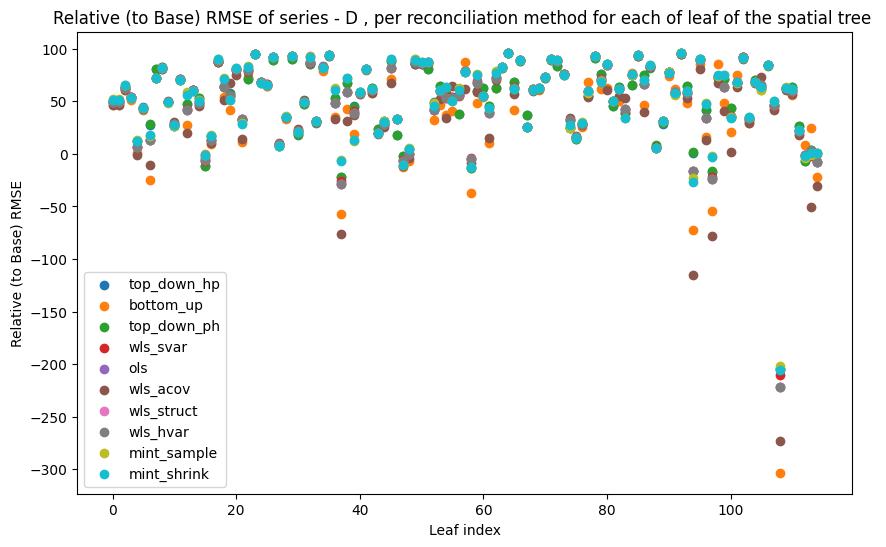

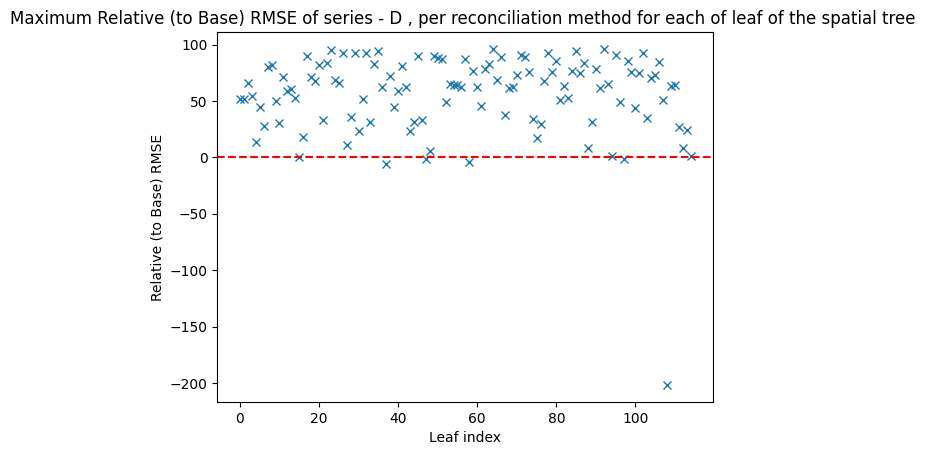

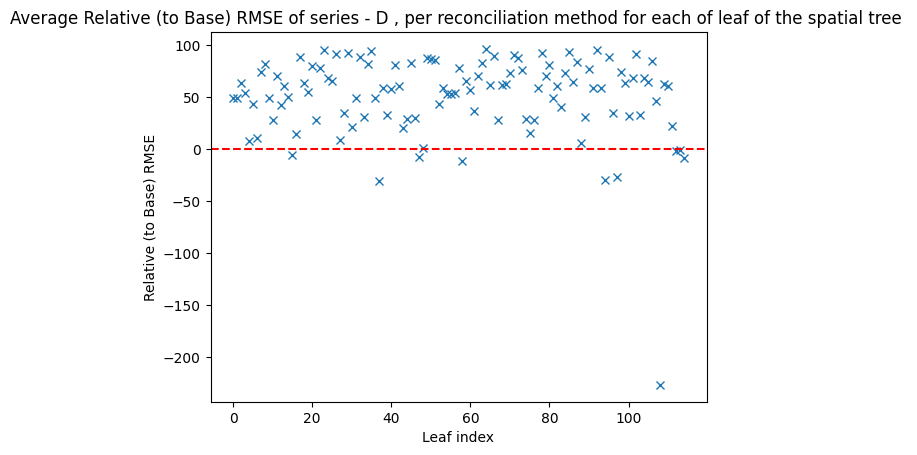

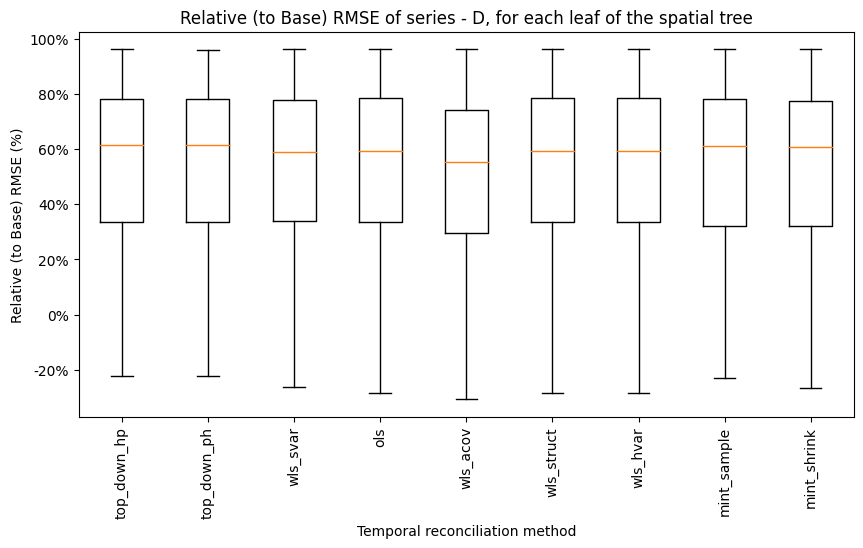

Table of counts the method was highest relative RMSE best in 113 temporal trees
______________________________________
bottom_up      14
mint_sample    38
mint_shrink     4
ols             1
top_down_hp    16
top_down_ph    17
wls_acov       22
wls_svar        3
dtype: int64
______________________________________


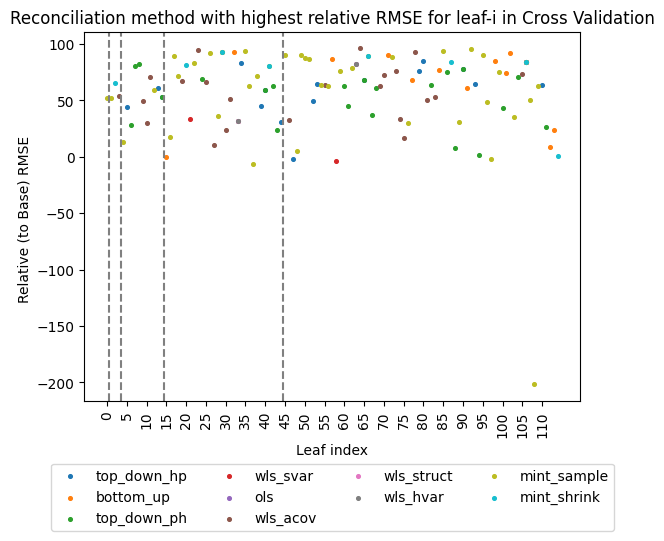

In [29]:
tree=Tree( dfData= df_data , sType='spatial') 
metric='RMSE'
relative='Base'
#relative='top_down_hp'

dfResults_relative=None


for level in ['D']:
    for  leaf in range(tree.mY.shape[0]):
        ddOutputs=dddISmatrices[leaf]
        if dfResults_relative is  None:
            dfResults_relative=pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)
        dfResults_relative=pd.concat([dfResults_relative,pd.DataFrame(getCVResults( h=1, iOoS=1, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, iters=None).loc[level].loc[:,relative]).T.reset_index(drop=True)])
        dfResults_relative.reset_index(drop=True,  inplace=True)
        
    # dfResults.drop(columns=['bottom_up'], inplace=True)    
    plt.figure(figsize=(10, 6))

    # Scatter plots for each column with the index as x-axis
    for method in dfResults_relative.columns:
        plt.scatter(dfResults_relative.index, dfResults_relative[method], label=method)
    plt.xlabel('Leaf index')
    # plt.ylim(0,50)
    plt.ylabel(f'Relative (to {relative}) {metric}')
    plt.legend()
    plt.title(f'Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
    plt.show()
    
    
plt.plot(dfResults_relative.T.max(), linestyle='',marker='x')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Leaf index')
plt.ylabel(f'Relative (to {relative}) {metric}')
plt.title(f'Maximum Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
plt.show()


plt.plot(dfResults_relative.T.mean(), linestyle='',marker='x')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Leaf index')
plt.ylabel(f'Relative (to {relative}) {metric}')
plt.title(f'Average Relative (to {relative}) {metric} of series - {level} , per reconciliation method for each of leaf of the spatial tree ')
plt.show()



import matplotlib.ticker as ticker

plt.figure(figsize=(10, 5))  # Adjust height
plt.boxplot(dfResults_relative.drop(columns=['bottom_up']), labels=dfResults_relative.drop(columns=['bottom_up']).columns, showfliers=False)
plt.xlabel('Temporal reconciliation method')
plt.xticks(rotation=90)
plt.ylabel(f'Relative (to {relative}) {metric} (%)')  # Update label to reflect percentage
plt.title(f'Relative (to {relative}) {metric} of series - {level}, for each leaf of the spatial tree')

# Format y-axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

plt.show()

        
sr=dfResults_relative.T.idxmax()
print(f'Table of counts the method was highest relative {metric} best in 113 temporal trees')
print("______________________________________")
print(sr.groupby(sr.values).count())
print("______________________________________")


df=dfResults_relative.apply(lambda row: row.where(row == row.max()), axis=1)
for method in dfResults_relative.columns:
    plt.scatter(df.index, df[method], label=method,s=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title(f'Reconciliation method with highest relative {metric} for leaf-i in Cross Validation')
plt.xlabel('Leaf index')
plt.xticks(ticks=df.index[::5], labels=df.index[::5], rotation=90)
plt.axvline(x=0.5,linestyle="--",color='grey')
plt.axvline(x=3.5,linestyle="--",color='grey')
plt.axvline(x=14.5,linestyle="--",color='grey')
plt.axvline(x=44.5,linestyle="--",color='grey')
plt.ylabel(f'Relative (to Base) {metric} ')
plt.show()

In [15]:
leaf=0
tree_spatial=Tree( dfData= df_data , sType='spatial') 
df_data_leaf=pd.DataFrame(data=tree_spatial.mY[leaf,:], index=tree_spatial.date_time_index[:] , columns=['y'])

tree_temporal=Tree(dfData=df_data_leaf, sType='temporal', iLeaf=leaf)

############
ddOutputs=tree_temporal.cross_validation(sTransform='log', dfHolidays=df_holidays,
                                iInitial=int(tree_temporal.mY.shape[1]*0.8),
                                iPeriod=time_converter(iOoS, from_unit='D' , to_unit='W'),
                                iHorizon=time_converter(iOoS, from_unit='D' , to_unit='W'),
                                lMethods=l_methods_temporal, sForecastMethod='prophet'
                                )
df_temporal_cv_results=getCVResults(h=time_converter(iOoS, from_unit='D' , to_unit='W'), 
                iOoS=time_converter(iOoS, from_unit='D' , to_unit='W'),
                ddOutputs=ddOutputs, metric='RMSE', 
                slices=[7,1],  #TODO
                rolling=True, iters=None)
sSelectedWeightType = df_temporal_cv_results.loc['D'].idxmax()[0] #[0] compared to base
print(sSelectedWeightType)

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of CV folds = 55
mint_sample
